# Setup (imports, constants, etc.)

See scikit-learn [FAQ][1] for multiprocessing issue info fixed below:

[1]:http://scikit-learn.org/stable/faq.html#why-do-i-sometime-get-a-crash-freeze-with-n-jobs-1-under-osx-or-linux

In [1]:
import multiprocessing

start_method = 'forkserver'
try:
    multiprocessing.set_start_method(start_method)
except RuntimeError as e:
    if str(e) != 'context has already been set':
        raise e
    elif multiprocessing.get_start_method() != start_method:
        raise RuntimeWarning(
            'Multiprocessing start_method {} was not set.'
            .format(start_method)
        )
        
N_JOBS = -1  # for sklearn

In [3]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from hdbscan import HDBSCAN
from IPython.display import display
from scipy import stats
from scipy.cluster import hierarchy
from scipy.misc import factorial
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, log_loss, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

from eda_plots import (
    plot_count_comparison, plot_interest_pie, plot_prob_x_for_hue,
    set_bedbath_groups
)
from main import (
    dump_pickle, read_rental_interest, save_submission, to_min_secs
)
from outlier_detection import (
    drop_bath_outl, drop_bbp_outl, drop_bed_outl, drop_geo_outl,
    drop_price_outl, imp_missing_baths, is_bath_outl, is_geo_outl,
    is_lat_outl, is_long_outl, is_outl_val, is_price_outl
)
from preprocessing import (
    AverageInterestExtractor, BoolFlagTransformer, DayBinarizer,
    GroupSumExtractor, ItemSelector, LatLongImputer, LenExtractor,
    LogTransformer, SqrtTransformer, ToFrame, WeekendExtractor,
    WordCntExtractor, concat_mappers, concat_pipelines, exp_int, feature_prep,
    get_word_cnt
)

%matplotlib inline

# Autoreload all imported modules at each execution.
%load_ext autoreload
%autoreload 2

pd.set_option('display.float_format', lambda x: '%.4f' % x)

SEED = 42
np.random.seed(SEED)

DAT_DIR = '../Data/'
REPORT_IMG_DIR = '../Report-Images/'

TRAIN_FP = ''.join([DAT_DIR, 'train.json'])
TEST_FP = ''.join([DAT_DIR, 'test.json'])
DF_TRAIN_PKL = ''.join([DAT_DIR, 'df_train.pkl'])
DF_TEST_PKL = ''.join([DAT_DIR, 'df_test.pkl'])

# Using built-in 'neg_log_loss' scoring param used for simplicity
# Source code shows exact same make_scorer call, kept for reference
scorer = make_scorer(log_loss, greater_is_better=False,
                     needs_proba=True)

scoring = 'neg_log_loss'

df = read_rental_interest(TRAIN_FP)
df_te = read_rental_interest(TEST_FP)

if DF_TRAIN_PKL not in glob.glob(DAT_DIR+'*'):
    dump_pickle(df, DF_TRAIN_PKL)
if DF_TEST_PKL not in glob.glob(DAT_DIR+'*'):
    dump_pickle(df_te, DF_TEST_PKL)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exploratory Data Analysis

## Train vs test data

In [2]:
df = read_rental_interest(DF_TRAIN_PKL)
df_te = read_rental_interest(DF_TEST_PKL)

df.shape, df_te.shape

((49352, 14), (74659, 13))

### Are datasets random samples from same source?

In [3]:
# Same size for easier comparisons
df_te = df_te.sample(n=len(df), random_state=SEED)

Kolmogorov-Smirnov p-value: 0.981
Show sampled same distribution very likely


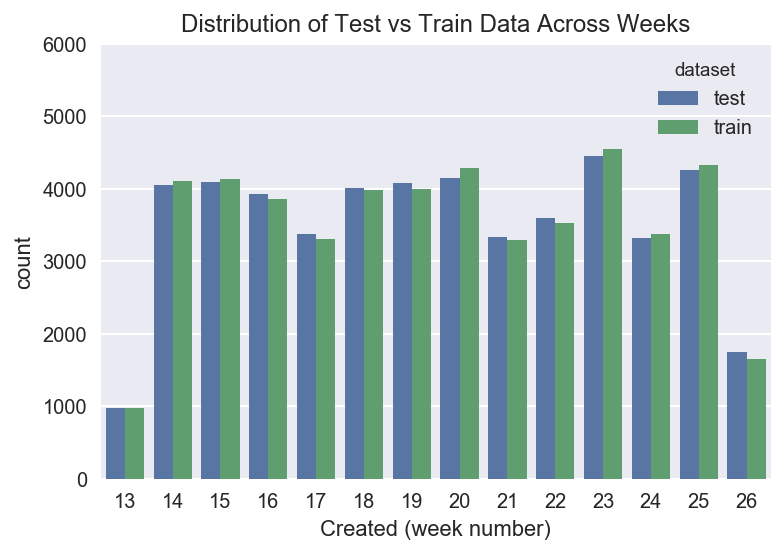

In [4]:
df_te = df_te.sample(n=len(df), random_state=SEED)
plot_count_comparison(
    x='week',
    df = df.assign(week=df.created.dt.week),
    df_te = df_te.assign(week=df_te.created.dt.week))

plt.ylim(0, 6000)
plt.xlabel('Created (week number)')
plt.title('Distribution of Test vs Train Data Across Weeks')

_, ks2_pval = stats.ks_2samp(df_te.created.dt.week, df.created.dt.week)
print('Kolmogorov-Smirnov p-value: {:.3f}'.format(ks2_pval))
print('Show sampled same distribution very likely')

plt.show()

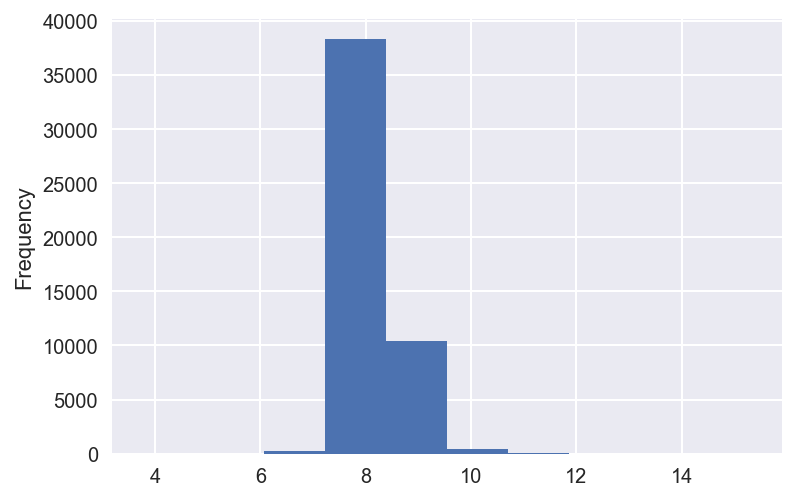

In [5]:
np.log(df.price).plot('hist')

Kolmogorov-Smirnov p-value: 0.940
Show sampled same distribution very likely


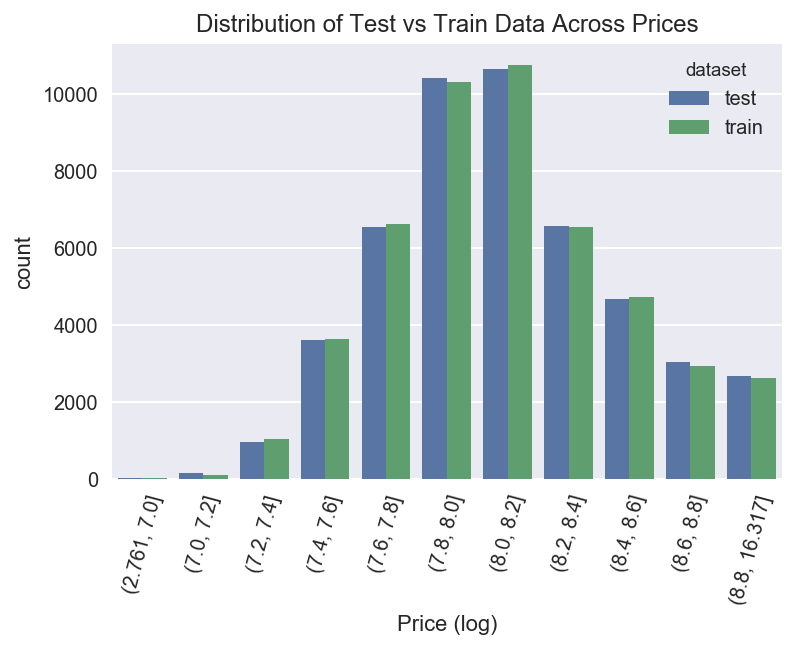

In [6]:
df_te = df_te.sample(n=len(df), random_state=SEED)

min_ = np.log(df.price.min()) - 1
max_ = np.log(df.price.max()) + 1
bins = [min_, 7, 7.2, 7.4, 7.6, 7.8, 8, 8.2, 8.4, 8.6, 8.8, max_]

data_tr = df.assign(lg_price=pd.cut(np.log(df.price), bins))
data_te = df_te.assign(lg_price=pd.cut(np.log(df_te.price), bins))

ax = plot_count_comparison(x='lg_price', df=data_tr, df_te=data_te)

plt.xticks(rotation=75)
plt.xlabel('Price (log)')
plt.title('Distribution of Test vs Train Data Across Prices')

_, ks2_pval = stats.ks_2samp(df_te.price, df.price)
print('Kolmogorov-Smirnov p-value: {:.3f}'.format(ks2_pval))
print('Show sampled same distribution very likely')

plt.show()

In [7]:
print('***Kolmogorov-Smirnov p-values***')
for name in df.drop('interest_level', axis=1).select_dtypes([int, float]).columns:
    _, ks2_pval = stats.ks_2samp(df[name], df_te[name])
    print('{:<10}: {:>5.3f}'.format(name, ks2_pval))

***Kolmogorov-Smirnov p-values***
bathrooms : 0.995
bedrooms  : 0.998
latitude  : 0.231
longitude : 0.747
price     : 0.940


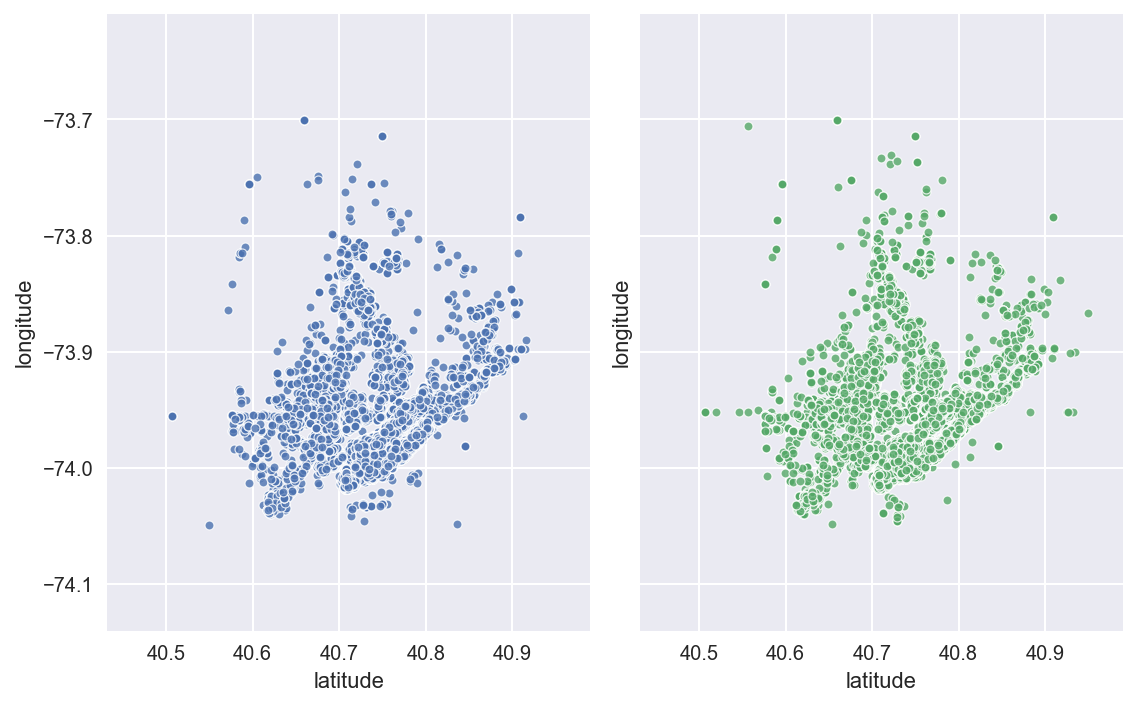

In [8]:
df1 = LatLongImputer().fit_transform(df).assign(dataset='train')
df2 = LatLongImputer().fit_transform(df_te).assign(dataset='test')

data = pd.concat([df1, df2])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 5),
                               sharex=True, sharey=True)

with sns.axes_style('white'):
    for ax, df in ((ax1, df1), (ax2, df2)):
        sns.regplot(x='latitude', y='longitude', data=df, fit_reg=False,
                    ax=ax, scatter_kws=dict(edgecolor='w', lw=.6, s=20)
)
plt.tight_layout()

In [9]:
df = read_rental_interest(DF_TRAIN_PKL)
df_te = read_rental_interest(DF_TEST_PKL)

In [10]:
tr_cnts = df.manager_id.value_counts()
te_cnts = df_te.manager_id.value_counts()

merged = pd.concat([tr_cnts, te_cnts], axis=1)
n_diff = merged.isnull().any(1).sum()
n_in_both = len(merged)-n_diff
print('{:.0%} of managers in both datasets'.format(n_in_both/len(merged)))

tr_cnts = df.building_id.value_counts()
te_cnts = df_te.building_id.value_counts()

merged = pd.concat([tr_cnts, te_cnts], axis=1)
n_diff = merged.isnull().any(1).sum()
n_in_both = len(merged)-n_diff
print('{:.0%} of buildings in both datasets'.format(n_in_both/len(merged)))

67% of managers in both datasets
45% of buildings in both datasets


### Are there any rentals listed twice?

In [11]:
df = read_rental_interest(DF_TRAIN_PKL)
df_te = read_rental_interest(DF_TEST_PKL)

df_all = pd.concat([df.drop('interest_level', axis=1), df_te])
df_all.shape

(124011, 13)

In [12]:
subset = ['bedrooms', 'bathrooms', 'price', 'building_id', 'manager_id']
is_dupe = df.duplicated(subset, keep=False)
df[is_dupe].sort_values(subset).T

listing_id,6842689,7112955,6834172,6872105,7162560,7028603,6921691,7032828,6978996,7002150,...,7074029,7232801,6989183,6999811,7006884,7017467,6895545,7216315,7093306,7159729
bathrooms,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,5.00000,5.00000,2.00000,2.00000,2.00000,2.00000,3.00000,3.00000,4.00000,4.00000
bedrooms,0,0,0,0,0,0,0,0,0,0,...,5,5,6,6,6,6,6,6,6,6
building_id,acf04eb24372da8ce23a7f73c3b099da,acf04eb24372da8ce23a7f73c3b099da,d8b20f7bd163403c49d242d50607cc0d,d8b20f7bd163403c49d242d50607cc0d,70093585319d049535fdc64e4f387da3,70093585319d049535fdc64e4f387da3,af79d0d2ed3d31362185fed210e97cb3,af79d0d2ed3d31362185fed210e97cb3,af79d0d2ed3d31362185fed210e97cb3,af79d0d2ed3d31362185fed210e97cb3,...,4c82773ff23782a525c36ff0699cb153,4c82773ff23782a525c36ff0699cb153,216377a6c7d73665e5a15db7663b1ef4,216377a6c7d73665e5a15db7663b1ef4,0,0,216377a6c7d73665e5a15db7663b1ef4,216377a6c7d73665e5a15db7663b1ef4,c349dabcf5a949ed6817a721adb7daab,c349dabcf5a949ed6817a721adb7daab
created,2016-04-08 02:56:02,2016-06-05 02:53:45,2016-04-06 08:04:51,2016-04-14 04:09:51,2016-06-15 03:00:25,2016-05-18 02:57:34,2016-04-25 02:34:07,2016-05-18 07:22:52,2016-05-07 03:14:38,2016-05-12 05:40:54,...,2016-05-27 02:33:39,2016-06-29 06:13:27,2016-05-10 03:15:08,2016-05-12 02:43:54,2016-05-13 04:56:06,2016-05-15 05:52:33,2016-04-19 05:40:00,2016-06-25 05:28:36,2016-06-01 06:07:31,2016-06-14 15:42:54
description,Spacious studio at Sullivan Mews.Sullivan Mews...,Spacious studio at Sullivan Mews--available la...,Studio on Upper West Side,Studio on Upper West Side,"90 West Street is a beautiful pre-war, full se...","90 West Street is a beautiful pre-war, full se...","upscale apartments complemented by beautiful, ...","upscale apartments complemented by beautiful, ...","upscale apartments complemented by beautiful, ...","upscale apartments complemented by beautiful, ...",...,Magnificent 5 bedroom / 5 bathroom duplex pent...,Magnificent 5 bedroom / 5 bathroom duplex pent...,This beautiful 6 bedroom apartment is brand ne...,This beautiful 6 bedroom apartment is brand ne...,TRUE 6 bedrooms and are Queen sized and 2 Ful...,TRUE 6 bedrooms and are Queen sized and 2 Ful...,"NO FEE!!!, Fantastic for sharing, bright 6 Bed...","Bright, Perfect for Sharing 6 Bedroom / 3 Bath...","Unique and rare 6 bedroom, 4 bath apartment wi...","Unique and rare 6 bedroom, 4 bath apartment wi..."
display_address,115 Sullivan Street,115 Sullivan Street,W 87th St,W 87th St,90 West Street,90 West Street,East 82nd Street,East 82nd Street,East 82nd Street,East 82nd Street,...,East 94th Street,East 94th Street,W 107 St.,W 107 St.,311 Broadway,311 Broadway,West 107th Street,West 107th Street,E 70th St,E 70th St
features,"[No Fee, Exclusive, Elevator]","[No Fee, Exclusive, Elevator]",[Elevator],[Elevator],"[Fitness Center, Residents Lounge, On-site Gar...","[Fitness Center, Residents Lounge, On-site Gar...","[Dining Room, Balcony, Doorman, Elevator, Laun...","[Dining Room, Balcony, Doorman, Elevator, Laun...","[Dining Room, Balcony, Doorman, Elevator, Laun...","[Dining Room, Balcony, Doorman, Elevator, Laun...",...,"[Dining Room, Balcony, Doorman, Elevator, Fitn...","[Dining Room, Balcony, Doorman, Elevator, Fitn...","[Elevator, Laundry in Building, Laundry in Uni...","[Elevator, Laundry in Building, Laundry in Uni...","[Elevator, Garden/Patio, Pre-War, Laundry in U...","[Elevator, Garden/Patio, Pre-War, Laundry in U...","[Pre-War, Laundry in Building, Dogs Allowed, C...","[Pre-War, Laundry in Building, No Fee, Dogs Al...","[Elevator, Laundry in Building, Dishwasher, Ha...","[Elevator, Laundry in Building, Dishwasher, Ha..."
interest_level,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,2,1,1,1
latitude,40.72600,40.72600,40.78940,40.78940,40.71000,40.71000,40.77600,40.77600,40.77600,40.77600,...,40.78260,40.78260,40.80150,40.80150,40.71570,40.71570,40.80150,40.80150,40.76760,40.76760
longitude,-74.00260,-74.00260,-73.97640,-73.97640,-74.01430,-74.01430,-73.95560,-73.95560

In [13]:
subset = ['bedrooms', 'bathrooms', 'price', 'building_id']
is_dupe = df_all.duplicated(subset, keep=False)
df_all[is_dupe].sort_values(subset).T

listing_id,7005340,7010798,6978506,6851809,7153326,6835131,6979910,6834974,6936950,6877851,...,6823981,7122976,7059766,6943719,6983545,6937105,7110293,7061389,6878604,6926894
bathrooms,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,4.00000,4.00000,4.00000,4.00000,4.00000,4.00000,4.00000,4.00000,5.50000,5.50000
bedrooms,0,0,0,0,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,7,7
building_id,f0410cd23d3856bbf8b42fd9b11ed619,f0410cd23d3856bbf8b42fd9b11ed619,f0410cd23d3856bbf8b42fd9b11ed619,f0410cd23d3856bbf8b42fd9b11ed619,d7b647fc80f992a06381b7f636dad338,d7b647fc80f992a06381b7f636dad338,5565db9b7cba3603834c4aa6f2950960,5565db9b7cba3603834c4aa6f2950960,5565db9b7cba3603834c4aa6f2950960,4559c07c932505a2e570a8c25f8465b6,...,87c4e08083ac83618dd9fdbf849331fe,c349dabcf5a949ed6817a721adb7daab,c349dabcf5a949ed6817a721adb7daab,0,0,0,8d83f6be6675419b19a6fc29a6ce6cee,8d83f6be6675419b19a6fc29a6ce6cee,2094beb4097c7f56670afba5b01b31a4,2094beb4097c7f56670afba5b01b31a4
created,2016-05-13 02:59:48,2016-05-14 03:01:53,2016-05-07 02:54:26,2016-04-10 02:49:58,2016-06-12 14:22:12,2016-04-06 18:12:38,2016-05-07 04:05:12,2016-04-06 18:05:35,2016-04-28 04:03:45,2016-04-15 04:59:14,...,2016-04-05 02:55:00,2016-06-08 02:10:53,2016-05-24 04:07:11,2016-04-29 06:30:33,2016-05-08 04:16:51,2016-04-28 04:14:55,2016-06-04 05:34:54,2016-05-24 05:59:12,2016-04-15 05:50:47,2016-04-26 05:37:31
description,Beautiful Studio with On Site Garage and Fitne...,In the heart of Brooklyn is a collection of in...,Fantastic Studio with On Site Garage and Fitne...,Gorgeous Studio with On Site Garage and Fitnes...,,,,,,,...,Rent listed is net effective after one month f...,"Apartment features king size six bedroom, four...",,Queen Size BedroomsEbony Hardwood FloorsRecess...,Nothing like this on the Upper East Side and 7...,Nothing like this on the Upper East Side and 7...,"This is a Brand New, Gut Renovated Large 6 Bed...","**NO FEE**This is a Brand New, Gut Renovated L...",SPECTACULAR PENTHOUSE IN THE SKY ! 5 bedroom /...,"GRAND ENTRANCE: FRAMED WITH LIMESTONE PIERS, O..."
display_address,1403 New York Avenue,1403 New York Ave.,1403 New York Avenue,1403 New York Avenue,Clarendon Rd,Clarendon Rd,Broadway,Broadway,Broadway,Grand Central Parkway West,...,E 77 St.,"E 70th St,",East 70th Street,East 75th Street,East 75th Street,East 75th Street,East 75th Street,East 75th Street\r,East 39th Street,East 39th Street
features,"[Fitness Center, On-site Garage, Laundry in Bu...","[Fitness Center, On-site Garage, Laundry in Bu...","[Fitness Center, On-site Garage, Laundry in Bu...","[Fitness Center, On-site Garage, Laundry in Bu...",[],[],"[Elevator, No Fee]",[Elevator],"[Elevator, No Fee]",[],...,"[Pre-War, Laundry in Unit, Dishwasher, Hardwoo...","[private-outdoor-space, balcony, Elevator, Sta...","[Doorman, Elevator, Cats Allowed, Dogs Allowed]","[Laundry in Unit, Dishwasher, Hardwood Floors,...","[Dining Room, Laundry in Unit, Dishwasher, Har...","[Dining Room, Laundry in Unit, Dishwasher, Har...","[Pre-War, Laundry in Unit, Hardwood Floors, No...","[Dining Room, Pre-War, Laundry in Unit, Dishwa...","[Fireplace, Swimming Pool, Roof Deck, Dining R...","[Swimming Pool, Roof Deck, Dining Room, Balcon..."
latitude,40.63860,40.63860,40.63860,40.63860,40.64350,40.64350,40.81980,40.81980,40.81980,40.71960,...,40.77160,40.76760,40.76760,40.77010,40.77010,40.77010,40.77010,40.77010,40.74790,40.74790
longitude,-73.94500,-73.94500,-73.94500,-73.94500,-73.94280,-73.94280,-73.95780,-73.95780,-73.95780,-73.83510,...,-73.95440,-73.96010,-73.96010,-73.95500,-73.95500,-73.95500,-73.95500,-73.95500,-73.97460,-73.97460
manager_id,9df32cb8dda19d3222d66e69e258616b,9df32cb8dda19d3222d66e69e258616b,9df32cb8dda19d3222d66e69e258616b,9df32cb8dda19d3222d66e69e258616b,9556a2e6dd5f856dfaf77cd09fb8af38,8f5a9c893f6d602f4953fcc0b8e6e9b4,8f5a9c893f6d602f4953fcc0b8e6e9b4,8f5a9c893f6d602f4953fcc0b8e6e9b4,8f5a9c893f6d602f4953fcc0b8e6e9b4,e6472c7237327dd3903b3d6f6a94515a,...,e6472c7237327dd3903b3d6f6a9

Duplicates on everything

In [14]:
data = df_all

subset = (data.drop(['manager_id', 'features', 'photos'], axis=1)
              .columns.tolist()
)
is_dupe = data.duplicated(subset, keep=False)
data[is_dupe].sort_values(subset).T

listing_id,6827050,7485494,7121825,6834448,7121804,6840762,7670925,6862495,6862503,7206163,...,7025421,7025420,7025763,7025764,7025922,7025923,7025164,7025163,7186031,7186030
bathrooms,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,2.50000,2.50000,3.00000,3.00000,3.00000,3.00000,3.50000,3.50000,4.50000,4.50000
bedrooms,0,0,0,0,0,0,0,0,0,0,...,3,3,3,3,3,3,4,4,4,4
building_id,0,0,0,0,0,0,0,0,0,0,...,b6a10b3e057d5ed75fb7ff31b83bf0b1,b6a10b3e057d5ed75fb7ff31b83bf0b1,1f08a2db498242410566a351799b12f0,1f08a2db498242410566a351799b12f0,5946e4ecda0d333735c2b04b5f4ec2e0,5946e4ecda0d333735c2b04b5f4ec2e0,5fb51b0c45b2ea4bc8bbeaa5c7c4895a,5fb51b0c45b2ea4bc8bbeaa5c7c4895a,3471bc324ab99b92a5b56763d25c8cf3,3471bc324ab99b92a5b56763d25c8cf3
created,2016-04-05 12:44:57,2016-04-05 12:44:57,2016-04-06 12:54:03,2016-04-06 12:54:03,2016-04-07 14:40:14,2016-04-07 14:40:14,2016-04-12 11:50:05,2016-04-12 11:50:05,2016-04-12 12:02:03,2016-04-12 12:02:03,...,2016-05-17 14:29:08,2016-05-17 14:29:08,2016-05-17 14:38:04,2016-05-17 14:38:04,2016-05-17 14:41:01,2016-05-17 14:41:01,2016-05-17 14:24:29,2016-05-17 14:24:29,2016-06-20 19:12:33,2016-06-20 19:12:33
description,TAKE A REDUCED FEE OR $ 1000 BONUS! \r\rStudio...,TAKE A REDUCED FEE OR $ 1000 BONUS! \r\rStudio...,This studio apartment has been newly renovated...,This studio apartment has been newly renovated...,This spacious studio apartment is right in the...,This spacious studio apartment is right in the...,- Beautiful Studio- Brand New Kitchen Applianc...,- Beautiful Studio- Brand New Kitchen Applianc...,Renovated studio apartment has new kitchen and...,Renovated studio apartment has new kitchen and...,...,This large convertible 3 bedroom soaked with n...,This large convertible 3 bedroom soaked with n...,Massive renovated 3 bedroom in a PreWar buildi...,Massive renovated 3 bedroom in a PreWar buildi...,"This is a Brand New, Gut Renovated 3 Bedroom D...","This is a Brand New, Gut Renovated 3 Bedroom D...",Large converted 4 BR/3.5 BA home w/ panoramic ...,Large converted 4 BR/3.5 BA home w/ panoramic ...,Sprawling floor-thru Penthouse unit located in...,Sprawling floor-thru Penthouse unit located in...
display_address,West Street,West Street,John St,John St,Wall St,Wall St,E 61 st,E 61 st,South End Avenue,South End Avenue,...,E 70th St.,E 70th St.,E 72nd St.,E 72nd St.,E 81 St.,E 81 St.,East 56th Street,East 56th Street,E 57 St.,E 57 St.
features,"[Common Outdoor Space, Laundry In Unit, Cats A...","[Common Outdoor Space, Laundry In Unit, Cats A...","[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Cats Allowed, Dogs Allowed, Elevator, Laundry...","[Cats Allowed, Dogs Allowed, Elevator, Laundry...","[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Common Outdoor Space, Cats Allowed, Dogs Allo...",...,"[Dining Room, Balcony, Doorman, Elevator, Terr...","[Dining Room, Balcony, Doorman, Elevator, Terr...","[Dining Room, Doorman, Elevator, Pre-War, Laun...","[Dining Room, Doorman, Elevator, Pre-War, Laun...","[Multi-Level, Pre-War, Laundry in Unit, Dishwa...","[Multi-Level, Pre-War, Laundry in Unit, Dishwa...","[Roof Deck, Doorman, Elevator, Laundry in Buil...","[Roof Deck, Doorman, Elevator, Laundry in Buil...","[Balcony, Doorman, Elevator, Terrace, Laundry ...","[Balcony, Doorman, Elevator, Terrace, Laundry ..."
latitude,40.70530,40.70530,40.70760,40.70760,40.70330,40.70330,40.76270,40.76270,40.71580,40.71580,...,40.76790,40.76790,40.76880,40.76880,40.77390,40.77390,40.75790,40.75790,40.75820,40.75820
longitude,-74.01140,-74.01140,-74.01050,-74.01050,-74.01400,-74.01400,-73.96900,-73.96900,-74.01560,-74.01560,...,-73.95980,-73.95980,-73.95920,-73.95920,-73.95290,-73.95290,-73.96530,-73.96530,-73.96340,-73.96340
manager_id,3734dac511776b0990e90a94d71c8251,3734dac511776b0990e90a94d71c8251,d12f4c3b61d726c5b7f74ff

In [15]:
data = df.drop('interest_level', axis=1)

subset = (data.drop(['manager_id', 'features', 'photos'], axis=1)
              .columns.tolist()
)
is_dupe = data.duplicated(subset, keep=False)
data[is_dupe].sort_values(subset).T

listing_id,6868769,7222580,7547579,7133023,7485458,7023521,7025062,7025061,7155593,6822458,...,7056185,6956382,7056191,6956411,7019955,7567437,7025646,7025645,7025421,7025420
bathrooms,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.50000,2.50000
bedrooms,0,0,0,0,0,0,0,0,0,0,...,2,2,3,3,3,3,3,3,3,3
building_id,0,0,0,0,c94301249b8c09429d329864d58e5b82,c94301249b8c09429d329864d58e5b82,d16f875956b264d5920d8424631091d4,d16f875956b264d5920d8424631091d4,fcd0bca4ee9c7bd444dbba39e8caa4fe,fcd0bca4ee9c7bd444dbba39e8caa4fe,...,f5e2cdb7a92059ee5e3dbd97b03f03ce,f5e2cdb7a92059ee5e3dbd97b03f03ce,315a2f868a195b076e5be73411110da2,315a2f868a195b076e5be73411110da2,d0234abbc01a982d54e8d446acc03405,d0234abbc01a982d54e8d446acc03405,dd7b281c0dbafc8b53575ab78cca75d4,dd7b281c0dbafc8b53575ab78cca75d4,b6a10b3e057d5ed75fb7ff31b83bf0b1,b6a10b3e057d5ed75fb7ff31b83bf0b1
created,2016-04-13 12:53:40,2016-04-13 12:53:40,2016-06-09 18:48:01,2016-06-09 18:48:01,2016-05-17 11:16:30,2016-05-17 11:16:30,2016-05-17 14:21:48,2016-05-17 14:21:48,2016-04-04 18:44:53,2016-04-04 18:44:53,...,2016-05-03 02:57:23,2016-05-03 02:57:23,2016-05-03 02:58:11,2016-05-03 02:58:11,2016-05-16 12:49:47,2016-05-16 12:49:47,2016-05-17 14:35:36,2016-05-17 14:35:36,2016-05-17 14:29:08,2016-05-17 14:29:08
description,"Spacious studio with oversized entry doors, hi...","Spacious studio with oversized entry doors, hi...",RENOVATED studio apartment. GREAT layout..feat...,RENOVATED studio apartment. GREAT layout..feat...,**IMMEDIATE OCCUPANCY** \r\rThis luxury St...,**IMMEDIATE OCCUPANCY** \r\rThis luxury St...,FEATURES:Custom European CabinetryGranite Coun...,FEATURES:Custom European CabinetryGranite Coun...,BETWEEN 65TH AND 66TH STREET \r\r*****BEST LOC...,BETWEEN 65TH AND 66TH STREET \r\r*****BEST LOC...,...,,,,,Great 2BDR convertible to 3BDR with windows in...,Great 2BDR convertible to 3BDR with windows in...,***INCREDIBLE BEAUTIFUL APARTMENT IN MURRAY HI...,***INCREDIBLE BEAUTIFUL APARTMENT IN MURRAY HI...,This large convertible 3 bedroom soaked with n...,This large convertible 3 bedroom soaked with n...
display_address,Financial District,Financial District,E 91st St,E 91st St,gold st.,gold st.,John St.,John St.,Lexington Ave Btwn 65th and 66th St.,Lexington Ave Btwn 65th and 66th St.,...,E 18th St,E 18th St,Avenue B,Avenue B,"W34 Drmn, Gym, Rooftop,","W34 Drmn, Gym, Rooftop,",Second Avenue,Second Avenue,E 70th St.,E 70th St.
features,"[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Common Outdoor Space, Cats Allowed, Dogs Allo...","[Cats Allowed, Elevator]","[Cats Allowed, Elevator]","[Cats Allowed, Dogs Allowed, No Fee, Elevator,...","[Cats Allowed, Dogs Allowed, Reduced Fee, Elev...","[Roof Deck, Doorman, Elevator, Fitness Center,...","[Roof Deck, Doorman, Elevator, Fitness Center,...",[],[],...,"[Cats Allowed, Dogs Allowed, Washer/Dryer, Dis...","[Cats Allowed, Dogs Allowed, Washer/Dryer, Dis...","[Washer/Dryer, Dishwasher]","[Washer/Dryer, Dishwasher]","[Cats Allowed, Dogs Allowed, No Fee, Doorman, ...","[Cats Allowed, Dogs Allowed, No Fee, Doorman, ...","[Balcony, Doorman, Elevator, Fitness Center, L...","[Balcony, Doorman, Elevator, Fitness Center, L...","[Dining Room, Balcony, Doorman, Elevator, Terr...","[Dining Room, Balcony, Doorman, Elevator, Terr..."
latitude,40.70870,40.70870,40.78150,40.78150,40.70840,40.70840,40.70750,40.70750,40.76620,40.76620,...,40.73440,40.73440,40.72790,40.72790,40.75220,40.75220,40.74130,40.74130,40.76790,40.76790
longitude,-74.01380,-74.01380,-73.95040,-73.95040,-74.00870,-74.00870,-74.00590,-74.00590,-73.96560,-73.96560,...,-73.98230,-73.98230,-73.97940,-73.97940,-73.99400,-73.99400,-73.97810,-73.97810,-73.95980,-73.95980
manager_id,e6472c7237327dd3903b3d6f6a94515a,e6472c7237327dd3903b3d6f6a94515a,2ec6c71d78dd9df9046ce6899ec42de8,2ec6c71d78dd9df9046ce6899ec42de8,43fd90ca9d06dd61aa8f985e61f9a0c0,43fd90ca9d06dd61aa8f985e61f9a0c0,501b52559fd21b3

In [16]:
data = df.drop(['interest_level'], axis=1)
data = df
data = (data.assign(n_feats=data.features.apply(lambda x: len(x)))
            .assign(n_photos=data.photos.map(lambda x: len(x)))
)

subset = (data.drop(['created', 'manager_id', 'features', 'photos'], axis=1)
              .columns.tolist()
)

is_dupe = data.duplicated(subset, keep=False)
print('same time, same manager: {}'.format(is_dupe.sum()))

same time, same manager: 5230


In [81]:
data = df.drop(['interest_level'], axis=1)

subset = (data.drop(['created', 'features', 'photos'], axis=1)
              .columns.tolist()
)


is_dupe = data.duplicated(subset, keep=False)
print('dupes for {}'.format('4'))
print(is_dupe.sum())

for col in ['description', 'price']:

    subset.remove(col)
    is_dupe = data.duplicated(subset, keep=False)
    print('dupes with different {}'.format(col))
    print(is_dupe.sum())

dupes for 4
74
dupes with different created
7123
dupes with different description
8329
dupes with different price
13625


## Interest Level

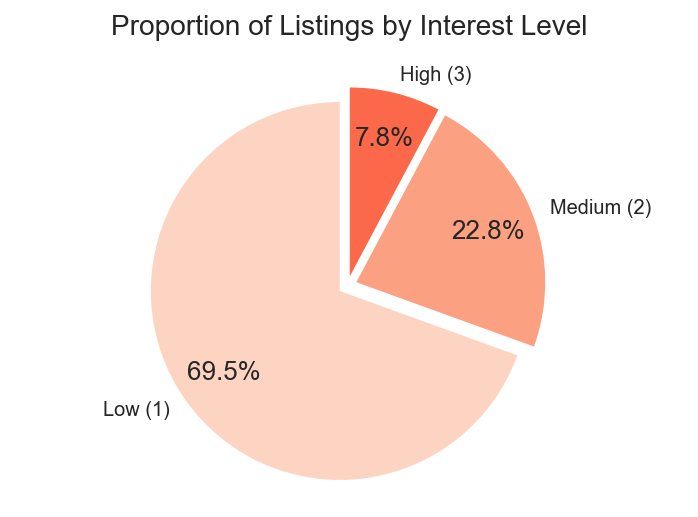

In [62]:
ax = plot_interest_pie(df.interest_level, textprops=dict(fontsize=13), pctdistance=.75)
ax.set_title(ax.get_title(), fontdict=dict(fontsize=14))

# plt.savefig(''.join([REPORT_IMG_DIR, '1-interest-pie.png']), dpi=600)
plt.show()


## Price

__Distribution__

count            inf
mean       3291.2812
std           1.5416
min          43.0000
25%        2500.0000
50%        3150.0000
75%        4100.0000
max     4490000.0000
Name: lg_price, dtype: float64

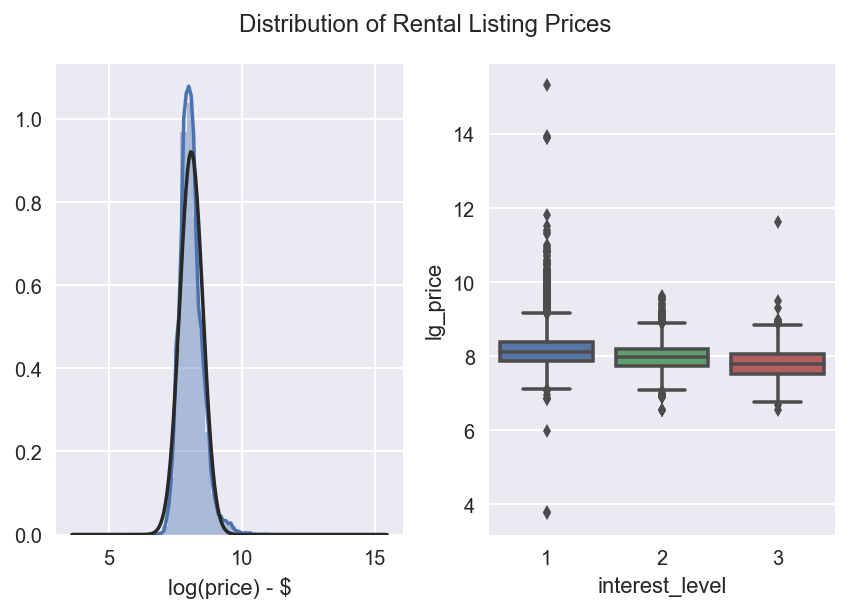

In [62]:
data = df.assign(lg_price=np.log(df.price))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 4))
sns.distplot(data.lg_price, fit=stats.norm, ax=ax1)
ax1.set_xlabel('log(price) - $')

sns.boxplot(y='lg_price', x='interest_level', data=data, ax=ax2)
plt.suptitle('Distribution of Rental Listing Prices', y=1.05)

plt.tight_layout()

# Std not accurate given transformations
display(data.lg_price.describe().apply(np.exp))

__Missing__

In [65]:
df.price.sort_values().head(10)

listing_id
7060255     43
6813772     45
6871682    401
6865783    695
6852585    695
6831246    695
6859573    695
7127753    700
6934177    800
6952911    868
Name: price, dtype: int64

Can consider 43 and 45 vals as missing values

__Missing Data and Outliers__

In [67]:
k = 3
price_outls = df[is_price_outl(df.price, k=k)].price

n_outl = len(price_outls)
print('{} ({:.2%}) outliers found with Tukey test with k={}'
      .format(n_outl, n_outl/len(df), k))
display(price_outls.sort_values().head())
display(price_outls.sort_values().tail())

165 (0.33%) outliers found with Tukey test with k=3


listing_id
7060255       43
6813772       45
6871682      401
7179590    18295
7209856    18457
Name: price, dtype: int64

listing_id
6857401     135000
7013217    1070000
7036279    1070000
7208794    1150000
7208764    4490000
Name: price, dtype: int64

__Relevance__

In [197]:
data.lg_price.min()

6.543911845564792

(0, 10000)

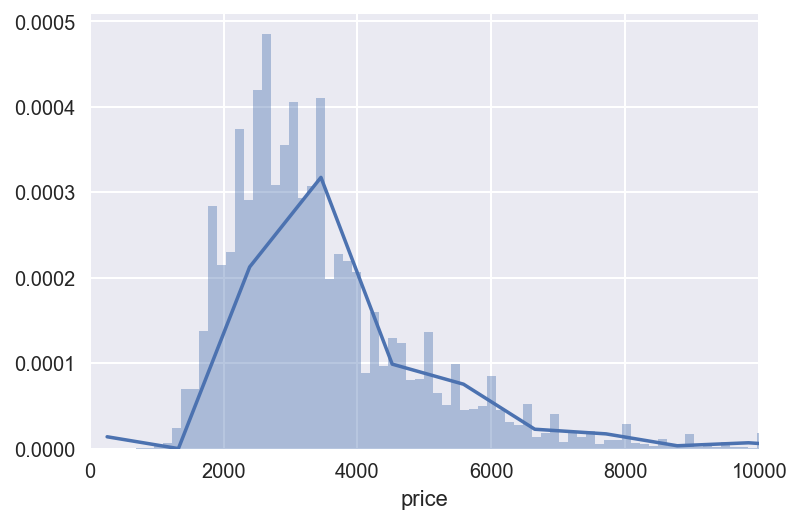

In [12]:
data = PriceOutlierDropper().fit_transform(data)
sns.distplot(data.price, bins=1000)
plt.xlim(0, 10000)

lg_price chi2 p-val = 0.0000 (rounded)


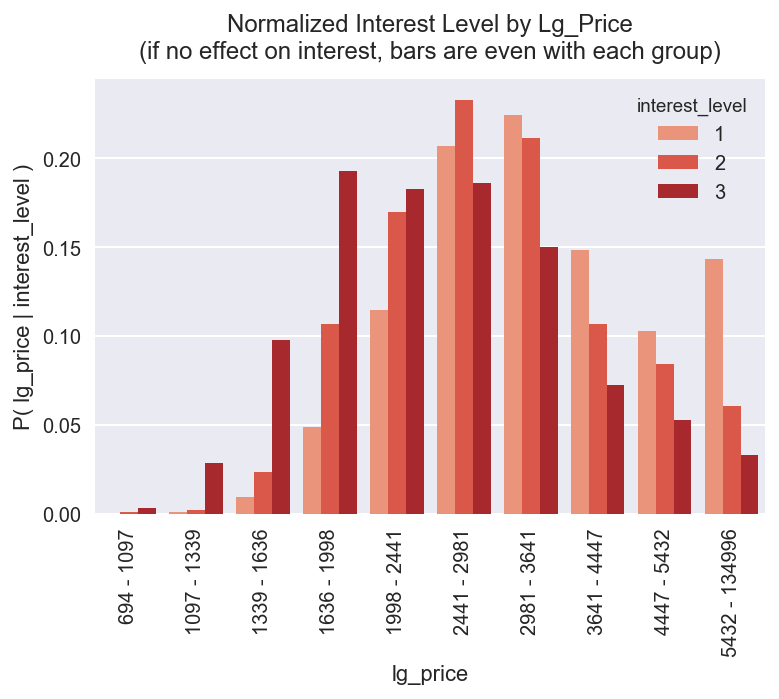

In [2]:
data = df.assign(lg_price=np.log(df.price))
data = PriceOutlierDropper().fit_transform(data)

bins = [data.lg_price.min(), 7, 7.2, 7.4, 7.6, 7.8, 8, 8.2, 8.4, 8.6,
        data.lg_price.max()]
plot_prob_x_for_hue(x='lg_price', data=data, hue='interest_level',
                    bins=bins, exp_xlabels=True)

# plt.savefig(''.join([REPORT_IMG_DIR, '2-price-on-interest.png']),
#             dpi=600, bbox_inches='tight')
plt.show()

## Bedrooms and Bathrooms

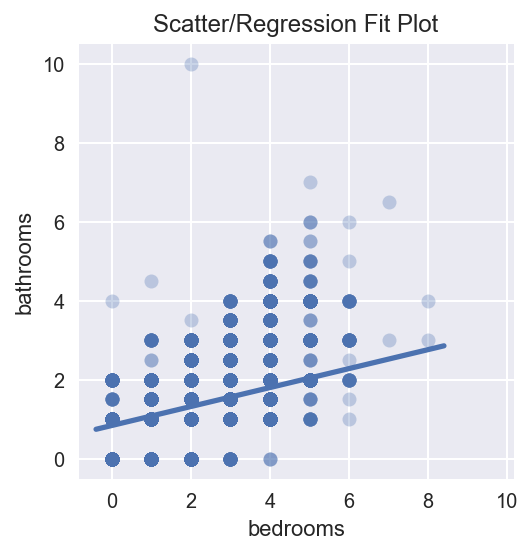

In [10]:
ax = sns.regplot(x='bedrooms', y='bathrooms', data=df,
                 scatter_kws=dict(alpha=.3))
ax.axis('square')
ax.set_title('Scatter/Regression Fit Plot')

# plt.savefig(''.join([REPORT_IMG_DIR, '4-bed-bath-scatter.png']),
#             dpi=600, bbox_inches='tight')

plt.show()

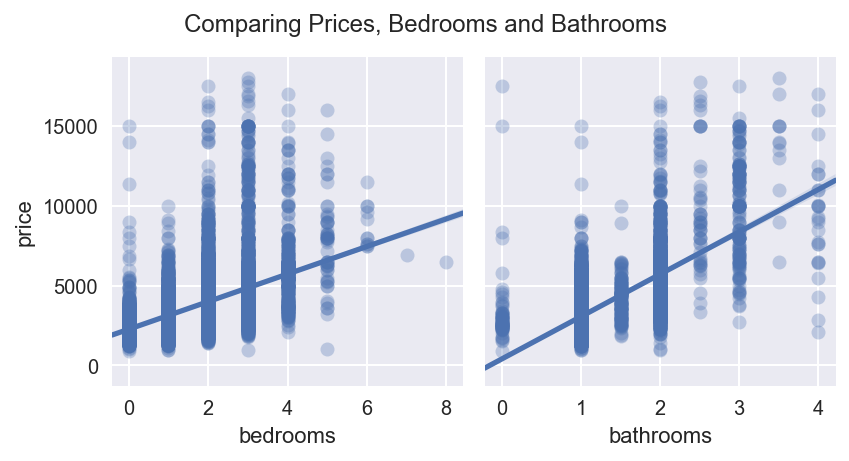

In [140]:
data = df[['bedrooms', 'bathrooms', 'price']]
data = drop_price_outl(data, k=3, msg=False)  # for plotting
data = data.sample(frac=.2, random_state=SEED)  # for performance

sns.pairplot(
    data=data,
    x_vars=['bedrooms', 'bathrooms'],
    y_vars=['price'],
    kind='reg',
    size=3,
    plot_kws=dict(scatter_kws=dict(alpha=.3)),
)
plt.suptitle('Comparing Prices, Bedrooms and Bathrooms', y=1.05)
plt.tight_layout()

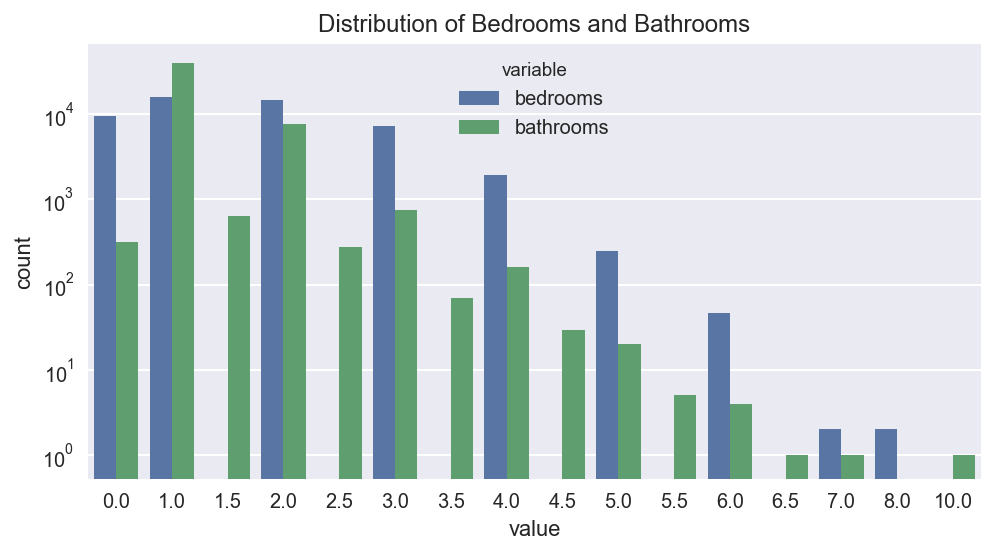

In [141]:
data = pd.melt(df, value_vars=['bedrooms', 'bathrooms'])
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='value', hue='variable', data=data, log=True)
plt.title('Distribution of Bedrooms and Bathrooms')

plt.show()

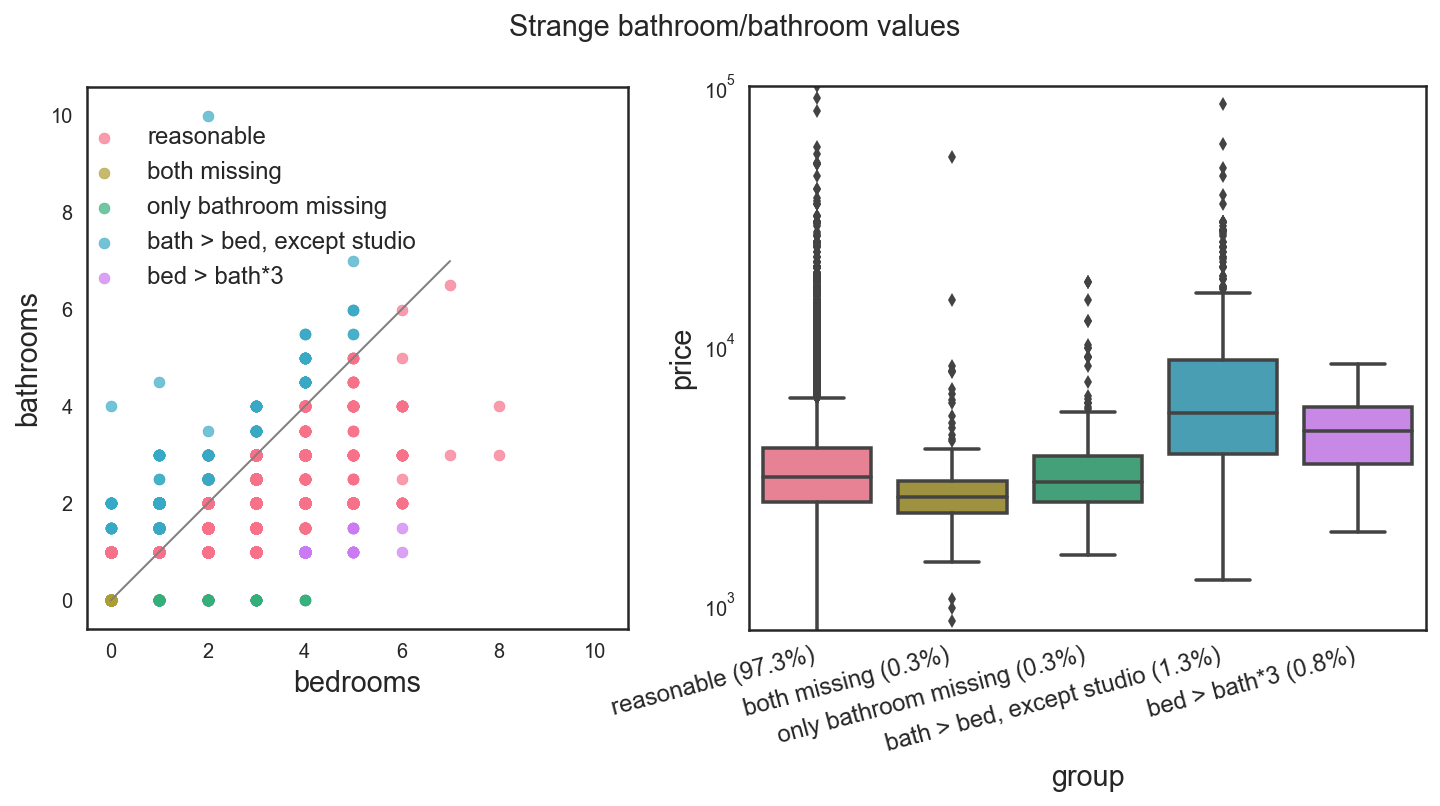

group counts


reasonable                   48023
bath > bed, except studio      634
bed > bath*3                   382
both missing                   157
only bathroom missing          156
Name: group, dtype: int64


Median Price by Group


group
bath > bed, except studio   5500.00000
bed > bath*3                4695.00000
both missing                2595.00000
only bathroom missing       2982.49057
reasonable                  3105.00000
Name: price, dtype: float64

In [32]:
data = set_bedbath_groups(df)

with sns.axes_style('white'):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5),
                                   gridspec_kw=dict(width_ratios=[4, 5]))

    grouped = data.groupby('group')
    
    group_order = ['reasonable', 'both missing', 'only bathroom missing',
                   'bath > bed, except studio', 'bed > bath*3']
    
    group_colors = sns.color_palette('husl', 5).as_hex()
    for color, name in zip(group_colors, group_order):
        group = grouped.get_group(name)
        group.plot(kind='scatter', x='bedrooms', y='bathrooms', label=name,
                   ax=ax1, color=color, s=30, alpha=.7)
    ax1.plot([0,7], [0,7], 'gray', linewidth=1)
    ax1.axis('square')
    ax1.legend(loc=(-.03, .61), fontsize='large')
    ax1.set_xlabel(ax1.get_xlabel(), fontsize='x-large')
    ax1.set_ylabel(ax1.get_ylabel(), fontsize='x-large')

    sns.boxplot(y='price', x='group', data=data,
                order=group_order, palette=group_colors, ax=ax2)

    xticklabels = []
    cnts = data.group.value_counts(normalize=True)
    for t in ax2.get_xticklabels():
        lbl = t.get_text()
        s = '{} ({:.1%})'.format(lbl, cnts[lbl])
        xticklabels.append(s)

    ax2.set_xticklabels(xticklabels, fontsize='large',
                        rotation=15, ha='right')
    ax2.set_xlabel(ax2.get_xlabel(), fontsize='x-large')
    ax2.set_ylabel(ax2.get_ylabel(), fontsize='x-large')
    
    ax2.set_yscale('log')
    ax2.set_ylim(800, 1e5)

    fig.suptitle('Strange bathroom/bathroom values', fontsize='x-large',
                 y=.98)

#     plt.savefig(''.join([REPORT_IMG_DIR, '3-strange-bed-bath.png']),
#                 dpi=600, bbox_inches='tight')
    plt.show()
    
print('group counts')
display(data.group.value_counts())
print()
print('Median Price by Group')
display(data.groupby('group')['price']
        .apply(lambda x: np.exp(np.median(np.log(x)))))

group chi2 p-val = 0.0000 (rounded)


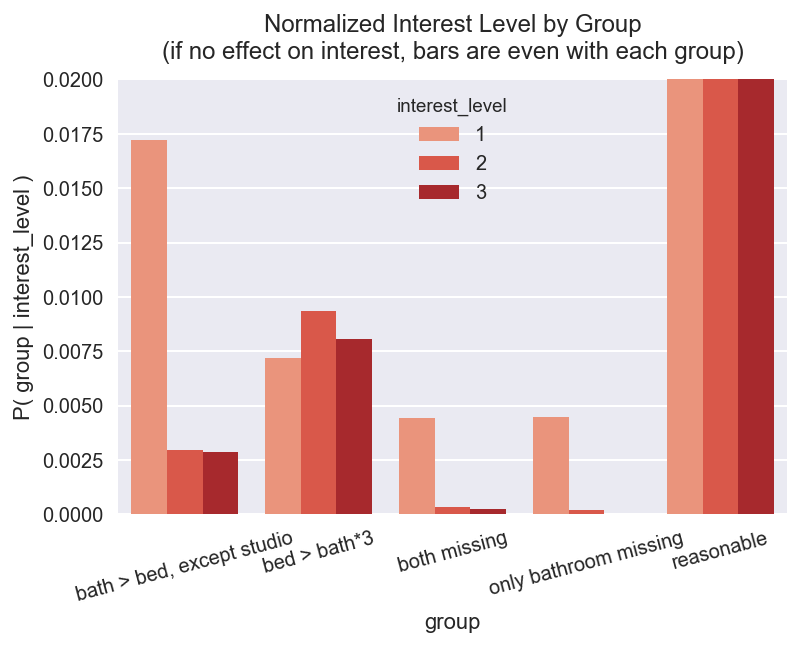

In [211]:
data = set_bedbath_groups(df)

ax = plot_prob_x_for_hue(x='group', data=data, hue='interest_level')
ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
plt.ylim(0, .02)
plt.show()

bedrooms chi2 p-val = 0.0000 (rounded)


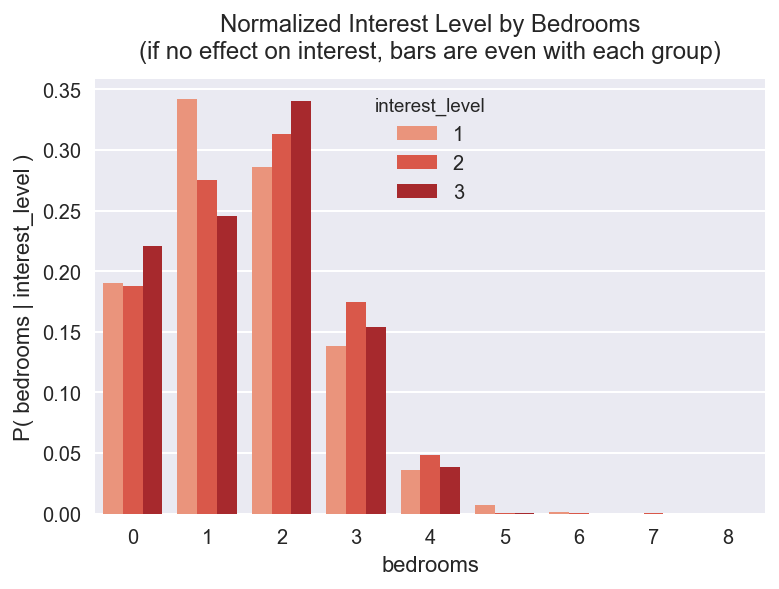

In [212]:
data = df
plot_prob_x_for_hue(x='bedrooms', data=data, hue='interest_level')
plt.show()

## Geo-coordinates and Buildings

In [217]:
df[df.latitude==0].shape

(12, 14)

In [107]:
df = read_rental_interest(DF_TRAIN_PKL)

In [114]:
df.shape

(49352, 14)

Dropped 68 geo-coordinate outliers (0.14%)


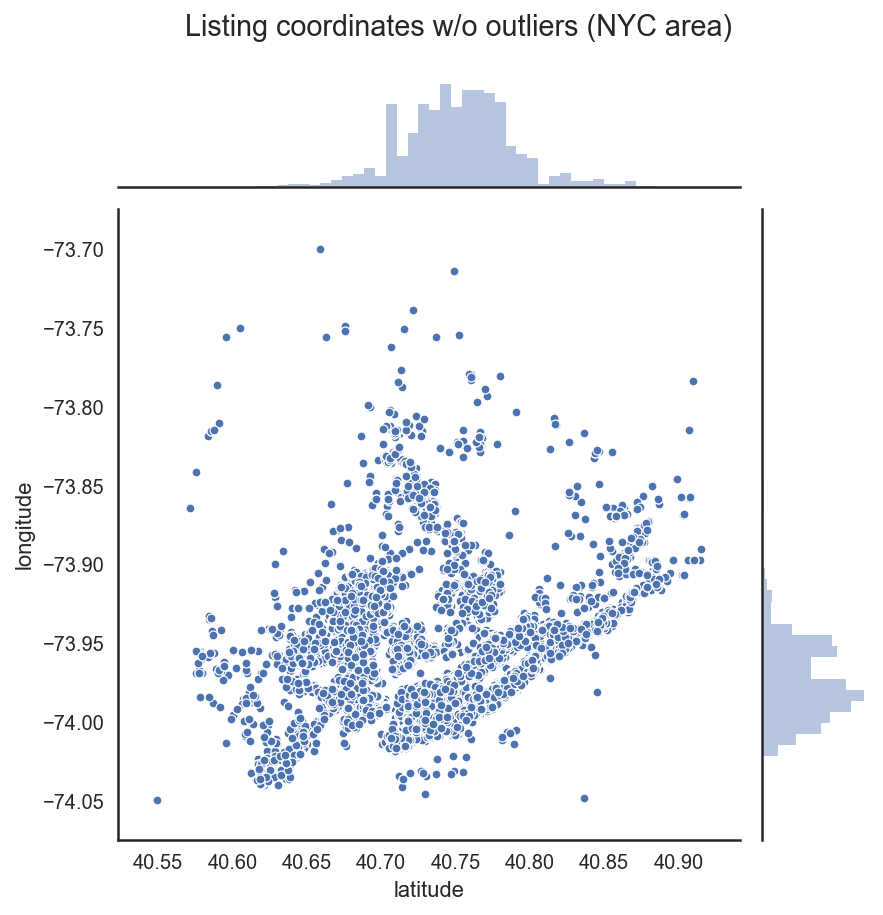

In [14]:
data = drop_geo_outl(df)
with sns.axes_style('white'):
    sns.jointplot('latitude', 'longitude', data=data, stat_func=None,
                  joint_kws=dict(edgecolor='w', lw=.6, s=20)
)
plt.suptitle('Listing coordinates w/o outliers (NYC area)', y=1.05,
             fontsize='x-large')
# plt.savefig(''.join([REPORT_IMG_DIR, '5a-geo-coordinates.png']),
#             dpi=600, bbox_inches='tight')
plt.show()

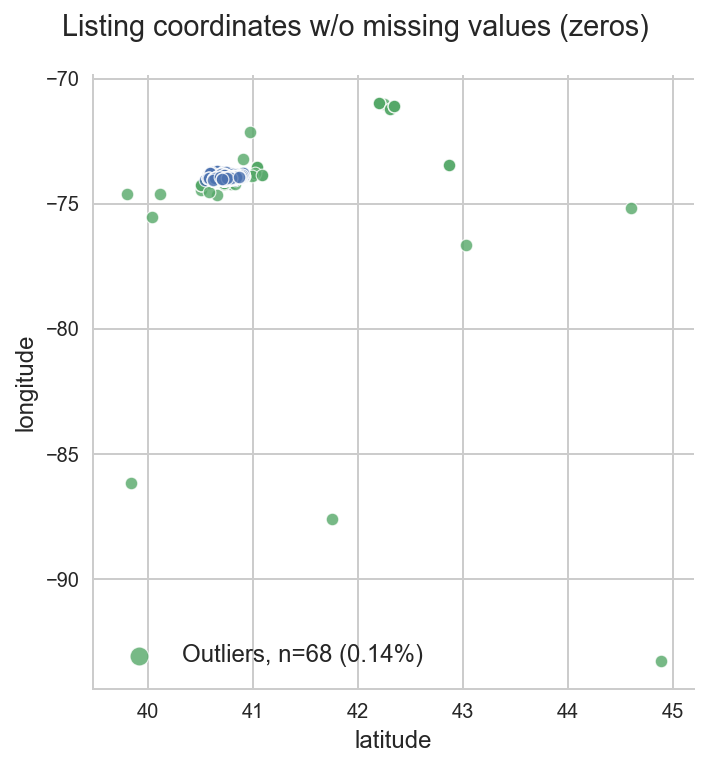

In [222]:
# invert colors so hue that needs to be plotted on top matches
# color of other coordinate scatter plot without outliers
with sns.axes_style('whitegrid'):
    with sns.color_palette(palette=sns.color_palette(palette='deep')[-5::-1]):
        
        # drop missing and one extreme outlier that distorts plot
        data = (df.query('latitude != 0 and longitude != 0')
                  .query('latitude != 34.01260 and longitude != -118.27100')
        )
        # indicate remaining outliers
        # empty string for column removes legend title
        data = data.assign(is_outlier=is_geo_outl(data.latitude, data.longitude))

        sns.lmplot(
            x='latitude', y='longitude', data=data, hue='is_outlier',
            fit_reg=False, hue_order=[True, False],
            legend_out=False, scatter_kws=dict(edgecolor='w', lw=.6, s=40),
        )
        plt.xlabel('latitude', fontsize='large')
        plt.ylabel('longitude', fontsize='large')
        
        plt.legend(['Outliers, n=68 (0.14%)'], loc='lower left',
                   markerscale=1.5, title=False, fontsize='large')
        plt.suptitle('Listing coordinates w/o missing values (zeros)',
                     fontsize='x-large', y=1.05)
#         plt.savefig(''.join([REPORT_IMG_DIR, '5b-geo-coordinates.png']),
#                     dpi=600, bbox_inches='tight')
        plt.show()


### Buildings vs Coordinates

Q: Is latitude and longitude determined by building?

A: No

In [120]:
print('Num buildings: {}'.format(len(df.building_id.unique())))
print('Num missing buildings: {}'.format(len(df[df.building_id=='0'])))

Num buildings: 7585
Num missing buildings: 8286


In [55]:
def has_same_coords(df):
    return df.duplicated(keep=False).all().all()

same_coords_dat = df.groupby('building_id')['latitude', 'longitude'].apply(
    lambda x: has_same_coords(x) if len(x) > 1 else np.nan
)
print('{} total buildings'.format(len(df.building_id.unique())))
print('{} only have one listing'.format((same_coords_dat.isnull()).sum()))
print('{} with same co-ordinates'.format(same_coords_dat.sum()))
print('{} with different co-ordinates'.format((same_coords_dat==False).sum()))

7585 total buildings
3659 only have one listing
2942 with same co-ordinates
984 with different co-ordinates


In [99]:
df[df.building_id=='0'].duplicated(['latitude', 'longitude'], keep=False).sum()

6291

How many geo-coordinate locations have multiple buildings?

In [117]:
building_diff = (df.groupby(['latitude', 'longitude'])['building_id']
                   .apply(lambda x: len(x.unique()))
                   .sort_values(ascending=False)
)

print((building_diff > 1).sum())
display(building_diff.head())

2219


latitude  longitude
0.00000   0.00000      11
40.71280  -74.00590     8
40.70690  -74.01040     4
40.74920  -73.97890     4
40.77920  -73.95140     4
Name: building_id, dtype: int64

How many buildings have listings with different geo-coordinates?

In [112]:
data = df.query('latitude != 0 and longitude != 0')
geo_coord_diff = (data.groupby('building_id')['latitude', 'longitude']
                    .apply(lambda x: x.max() - x.min())
)

print((geo_coord_diff.sum(1) > 0).sum())
display(geo_coord_diff.sort_values('latitude', ascending=False).head(20))
display(geo_coord_diff.sort_values('longitude', ascending=False).head(20))

1439


,latitude,longitude
building_id,,
cca9ed74339903b6d9c876a8e608d75b,4.12000,19.31200
0,2.91870,5.62760
437454e6d44ae7c94f60b1b6507d084a,0.91780,12.18180
ebdf422b8605d69a719a5cdc34019463,0.87690,0.66750
6869a3c2a96003e9992d6cd1c3c4b299,0.71720,1.53520
cd759a988b8f23924b5a2058d5ab2b49,0.16170,0.05060
3a6e1c689ffe82c668efccdcabb3664d,0.14260,0.07980
0dfc470e829c89405e597fd0bb9a4c55,0.07450,0.03260
b809c009c803e70c221317657ea96ec8,0.06700,0.08440


,latitude,longitude
building_id,,
cca9ed74339903b6d9c876a8e608d75b,4.12000,19.31200
437454e6d44ae7c94f60b1b6507d084a,0.91780,12.18180
0,2.91870,5.62760
6869a3c2a96003e9992d6cd1c3c4b299,0.71720,1.53520
95fabd330f806524ae62115264f1f840,0.02020,0.71240
ebdf422b8605d69a719a5cdc34019463,0.87690,0.66750
39dd015bc8b81e4ae8b667357b8620b4,0.03150,0.19900
c391084ee341be0d85643b7bd1757993,0.03850,0.13900
888101a642929bc225eae5f809a70bc8,0.02000,0.10890


Rounding geo-coordinates:
- Latitude
    - "Each degree of latitude is approximately 69 miles (111 kilometers) apart."
    - 5 ft = 0.00094697 miles = 0.000013724 degrees
    - 
- Longitude
    - "At 40° north or south, the distance between a degree of longitude is 53 miles (85 kilometers)."
    - 5 ft = 0.00094697 miles = 0.000017867 degrees


Source: https://www.thoughtco.com/degree-of-latitude-and-longitude-distance-4070616

## Dates

day_name chi2 p-val = 0.0000 (rounded)
month chi2 p-val = 0.3784 (rounded)


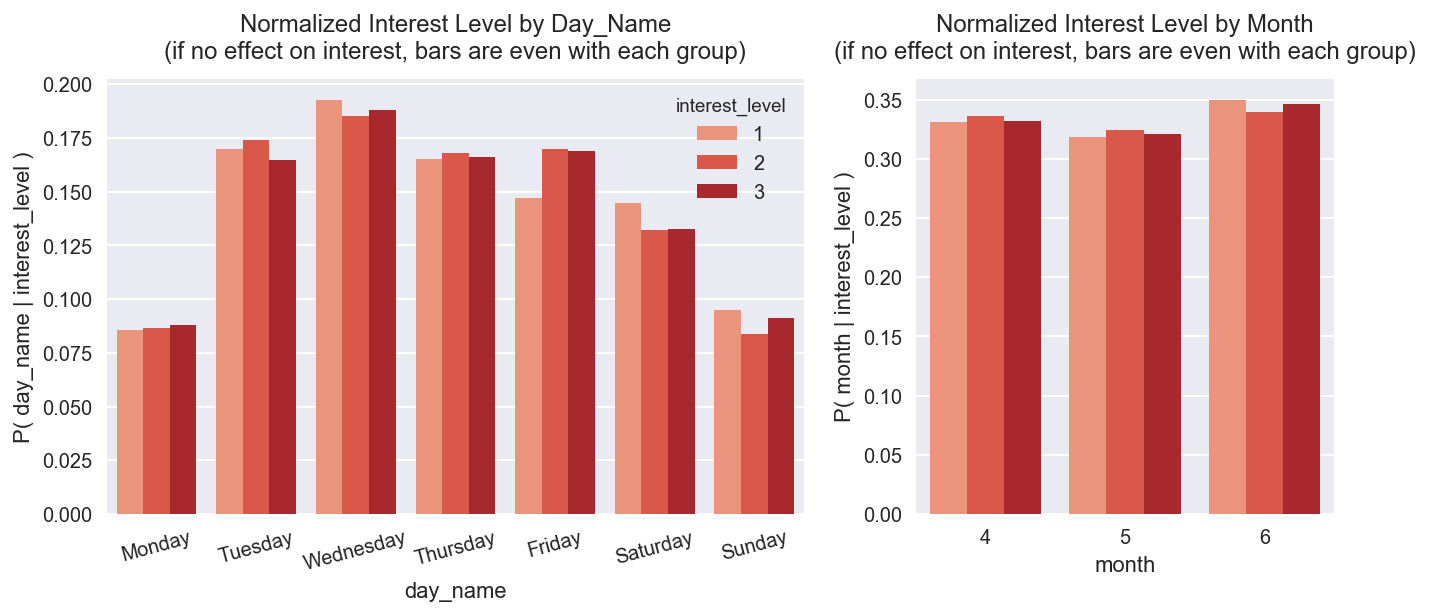

In [30]:
df['month']    = df.created.map(lambda x: x.month).astype(int)
df['day']      = df.created.map(lambda x: x.day).astype(int)
df['day_name'] = df.created.dt.weekday_name

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
             'Friday', 'Saturday', 'Sunday']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11, 4),
                               gridspec_kw=dict(width_ratios=[5, 3]))
plot_prob_x_for_hue(x='day_name', data=df, hue='interest_level',
                    bins=None, order=day_order, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15)

plot_prob_x_for_hue(x='month', data=df, hue='interest_level',
                    bins=None, ax=ax2)
ax2.legend('')

# plt.savefig(''.join([REPORT_IMG_DIR, '6-dates-on-interest.png']),
#             dpi=600, bbox_inches='tight')

plt.show()

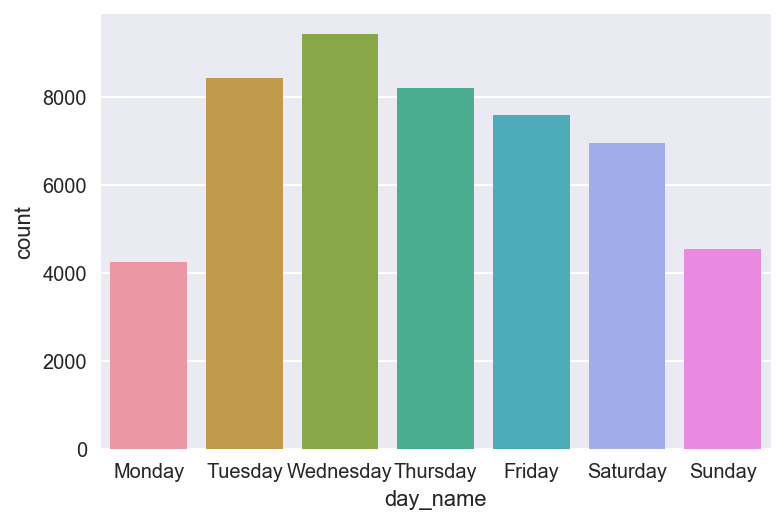

In [58]:
sns.countplot(x='day_name', data=df, order=day_order)

In [10]:
days = [
    'created_Friday',
    'created_Monday',
    'created_Saturday',
    'created_Sunday',
    'created_Thursday',
    'created_Tuesday',
    'created_Wednesday']
ls = []
for day in days:
    ls.append("{}='',".format(day))
    
print('\n'.join(ls))

created_Friday='',
created_Monday='',
created_Saturday='',
created_Sunday='',
created_Thursday='',
created_Tuesday='',
created_Wednesday='',


In [111]:
columns = [
    'created_Friday',
    'created_Monday',
    'created_Saturday',
    'created_Sunday',
    'created_Thursday',
    'created_Tuesday',
    'created_Wednesday']

days = pd.DataFrame(DayBinarizer().fit_transform(df.created),
                    columns=columns)

['21.783%', '19.870%', '18.716%', '17.122%', '12.093%', '10.417%', '0.000%']


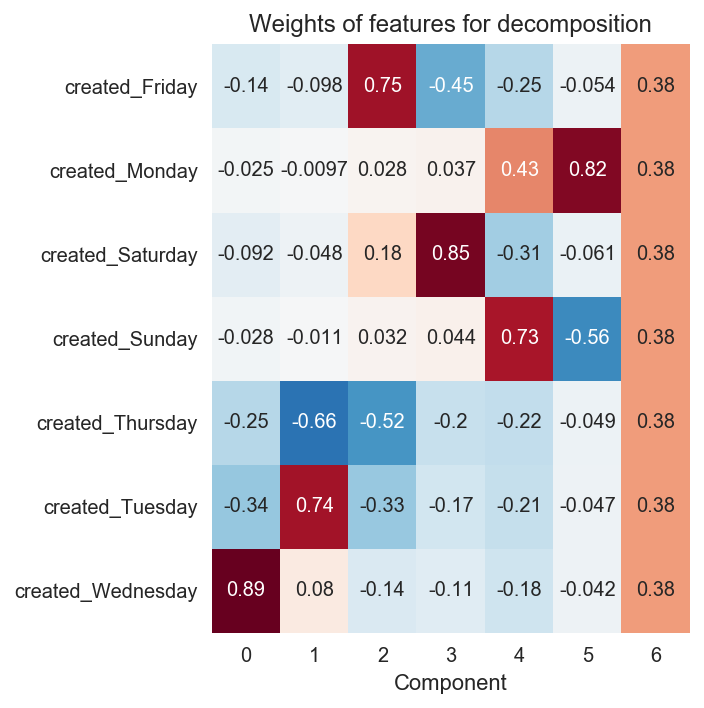

In [120]:
reducer = PCA()

reduced = reducer.fit_transform(days)
explained_variance = reducer.explained_variance_ratio_
print(['{:.3%}'.format(x) for x in explained_variance])

plt.figure(figsize=(5, 5))
sns.heatmap(reducer.components_.T, yticklabels=days.columns.tolist(),
            cbar=False, annot=True)

plt.title('Weights of features for decomposition')
plt.xlabel('Component')

plt.tight_layout();

## Addresses

In [512]:
df = read_rental_interest(DF_TRAIN_PKL)

Dropped 68 geo-coordinate outliers (0.14%)


How many missing display addresses have street addresses?

In [539]:
df[(df.street_address!='') & (df.display_address=='')].shape

(126, 14)

How many missing display addresses?

In [540]:
df[df.display_address==''].shape

(135, 14)

In [521]:
print('{} unique display addresses'.format(len(df.display_address.unique())))

8826 unique display addresses


In [522]:
df.display_address.value_counts().head()

Broadway            438
East 34th Street    355
Second Avenue       349
Wall Street         332
West 37th Street    287
Name: display_address, dtype: int64

How many listings have the same display address but different coordinates?

In [34]:
addr_cnts = df.groupby('display_address').apply(
    lambda x: len(x.latitude.unique()))

print((addr_cnts>1).sum())
display(addr_cnts.sort_values(ascending=False).head())

1951


display_address
                    117
Broadway             67
Second Avenue        63
First Avenue         56
Lexington Avenue     40
dtype: int64

## Number of Photos

n_photos chi2 p-val = 0.0000 (rounded)


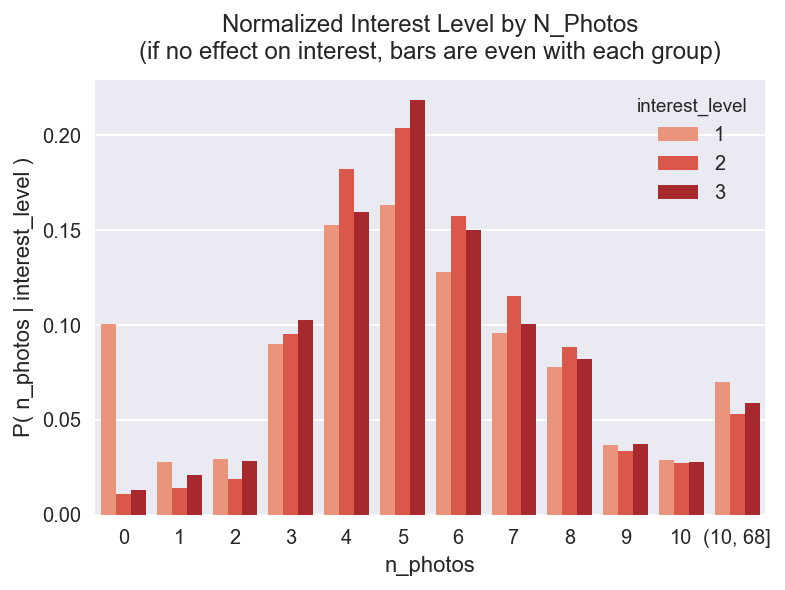

In [262]:
# do number of photos affect interest?
x = 'n_photos'
hue = 'interest_level'
data = df.assign(n_photos=df.photos.map(lambda x: len(x)))

bins = list(range(-1, 11)) + [data[x].max()]
ax = plot_prob_x_for_hue(x, data, hue, bins=bins)


ax.set_xticklabels(list(range(11)) + ['(10, 68]'], rotation=0)

# plt.savefig(''.join([REPORT_IMG_DIR, '7-n-photos-on-interest.png']),
#             dpi=600, bbox_inches='tight')

plt.show()

## Number of Features

n_feats chi2 p-val = 0.0000 (rounded)


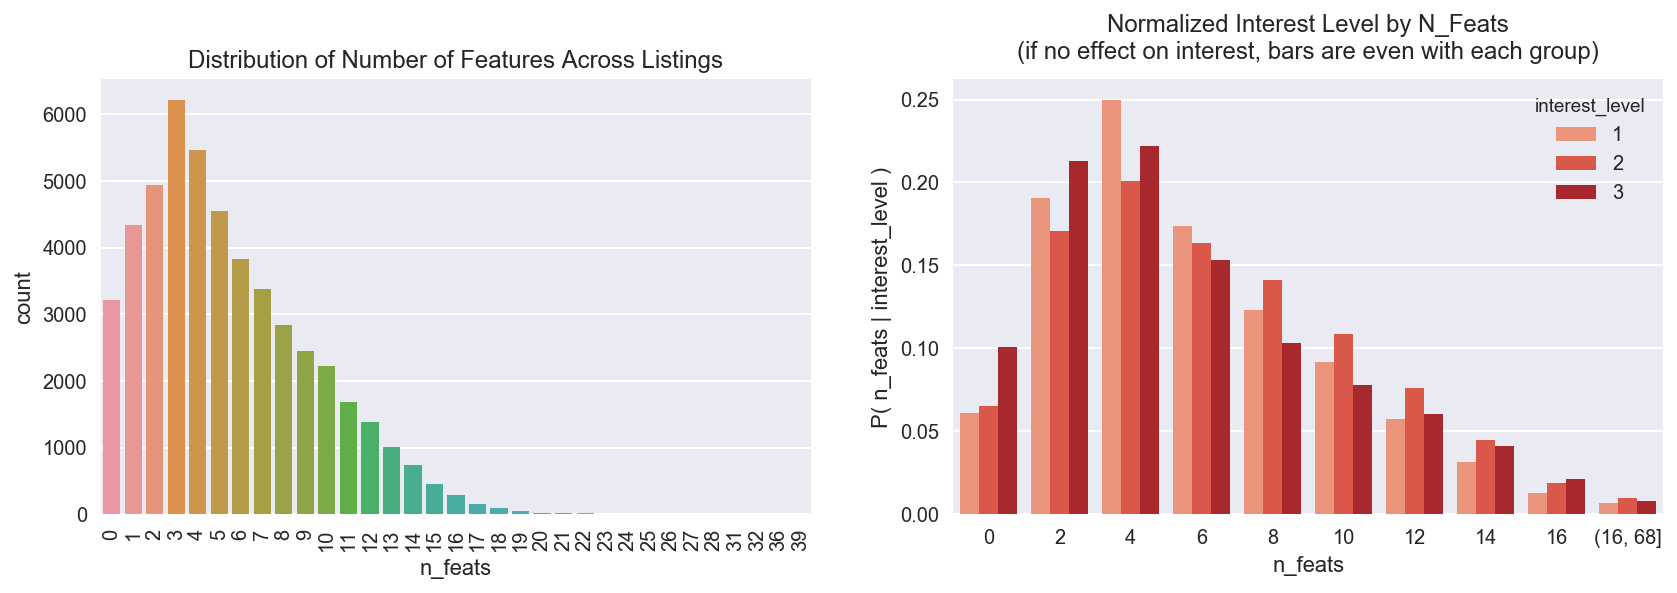

In [277]:
# do number of features affect interest?
data = df.assign(n_feats=df.features.apply(lambda x: len(x)))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 4))

sns.countplot(data.n_feats, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title('Distribution of Number of Features Across Listings')

x = 'n_feats'
hue = 'interest_level'
bins = [-1] + list(range(0, 17, 2)) + [data[x].max()]
plot_prob_x_for_hue(x, data, hue, bins, ax=ax2)

ax2.set_xticklabels(list(range(0, 17, 2)) + ['(16, 68]'], rotation=0)

# plt.savefig(''.join([REPORT_IMG_DIR, '8-n-feats-on-interest.png']),
#             dpi=600, bbox_inches='tight')

plt.show()

## Description Word Count

descr_wcnt chi2 p-val = 0.0000 (rounded)


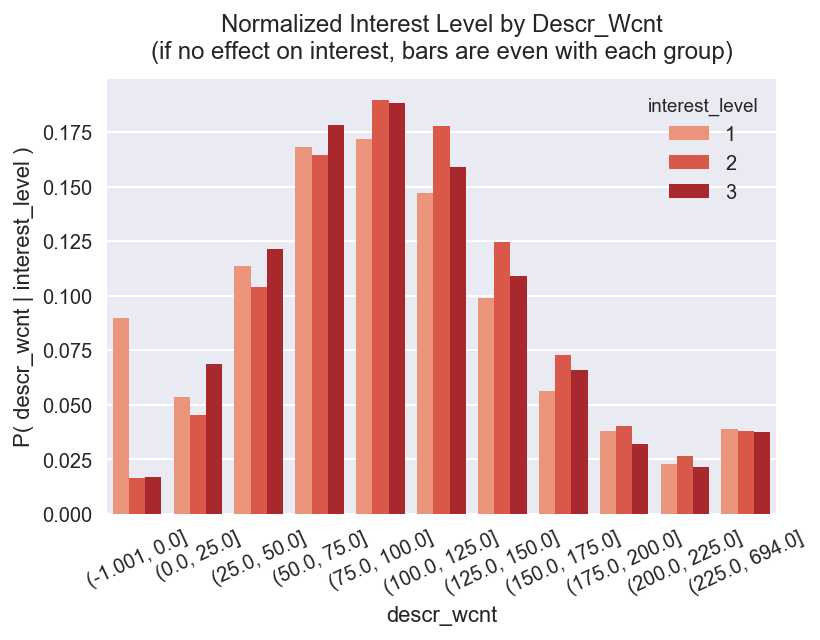

In [278]:
# does length of description affect interest?
data = df.assign(descr_wcnt=df.description.apply(get_word_cnt))
x = 'descr_wcnt'
hue = 'interest_level'

bins = [-1] + list(range(0, 226, 25)) + [data.descr_wcnt.max()]
plot_prob_x_for_hue(x=x, data=data, hue=hue, bins=bins)

plt.xticks(rotation=25)

# plt.savefig(''.join([REPORT_IMG_DIR, '9-descrip-wcnt-on-interest.png']),
#             dpi=600, bbox_inches='tight')

plt.show()

### Scaling of count features

In [70]:
scl_len_mapper = DataFrameMapper([
    ('photos', [LenExtractor(), StandardScaler()],
         {'alias': 'n_photos'}),
    ('features', [LenExtractor(), SqrtTransformer(), StandardScaler()],
         {'alias': 'n_feats'}),
    ('description', [WordCntExtractor(), SqrtTransformer(), StandardScaler()],
         {'alias': 'descr_wcnt'}),
], input_df=True, df_out=True)


data = scl_len_mapper.fit_transform(df)

fig, axs = plt.subplots(nrows=3, figsize=(5, 10))

for (_, ser), ax in zip(data.items(), axs):
    sns.distplot(ser, ax=ax)

/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


## Manager Activity and Performance

- Total posts
- Posts/duration
- Rating/post

In [3]:
df = read_rental_interest(DF_TRAIN_PKL)

n_posts chi2 p-val = 0.0000 (rounded)


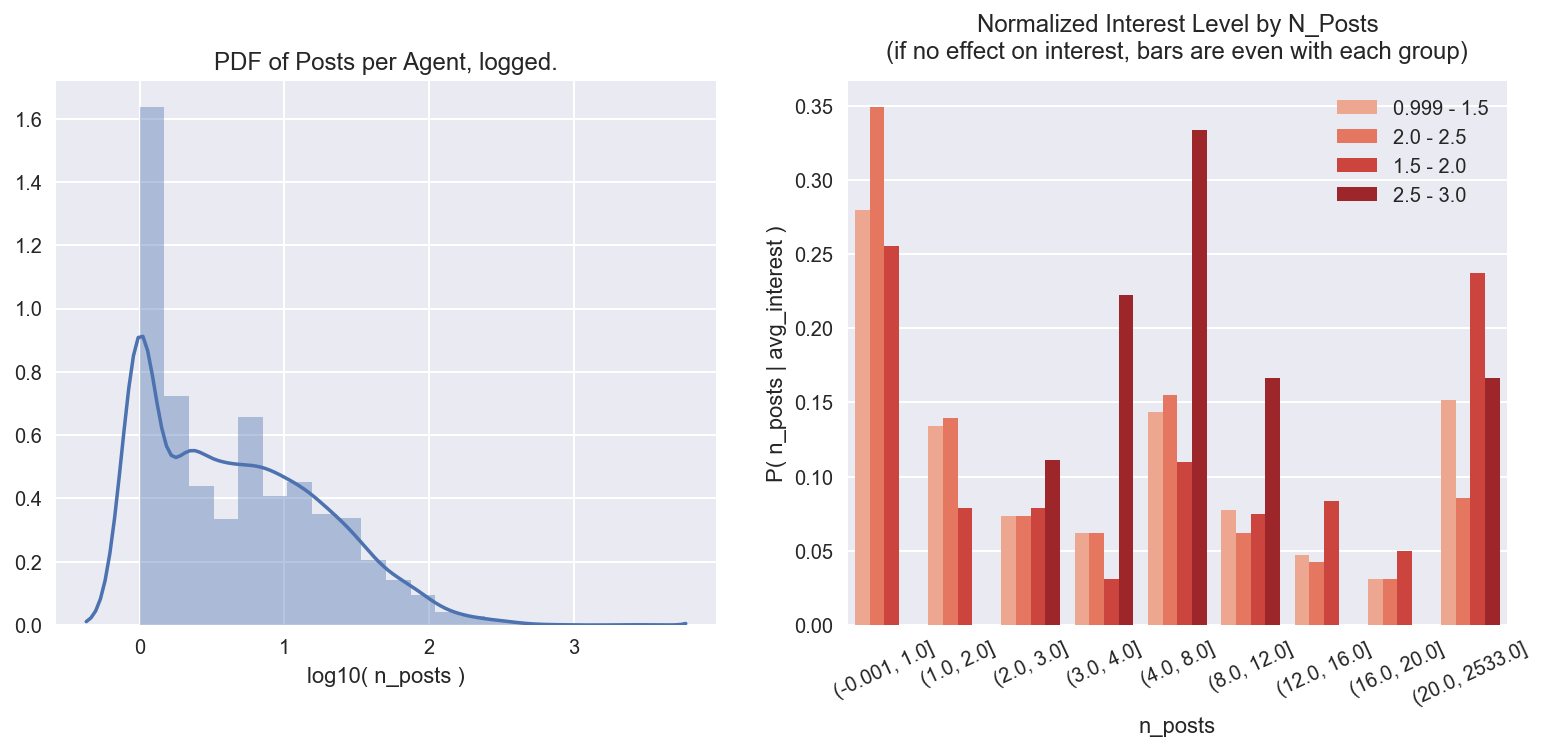

In [5]:
# see if activity of agents affects interest

prior = df.interest_level.mean()
avg_int = (df.groupby('manager_id')['interest_level']
           .apply(exp_int, prior)
#            .mean()
           .rename('avg_interest')
)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 5))
n_posts = df.manager_id.value_counts().rename('n_posts')

ax1 = sns.distplot(np.log10(n_posts), bins=20, ax=ax1)

ax1.set_xlabel('log10( n_posts )')
ax1.set_title('PDF of Posts per Agent, logged.')

data = pd.concat([n_posts, avg_int], axis=1)
x = 'n_posts'
hue = 'avg_interest'

bins = [0, 1, 2, 3] + list(range(4, 24, 4)) + [data.n_posts.max()]
hue_bins = [1, 1.5, 2, 2.5, 3]
ax2= plot_prob_x_for_hue(x=x, data=data, hue=hue, bins=bins,
                          hue_bins=hue_bins, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=25)
plt.legend(loc='upper right')

plt.savefig(''.join([REPORT_IMG_DIR, '10-n-posts-on-avg-interest.png']),
            dpi=600, bbox_inches='tight')

plt.show()

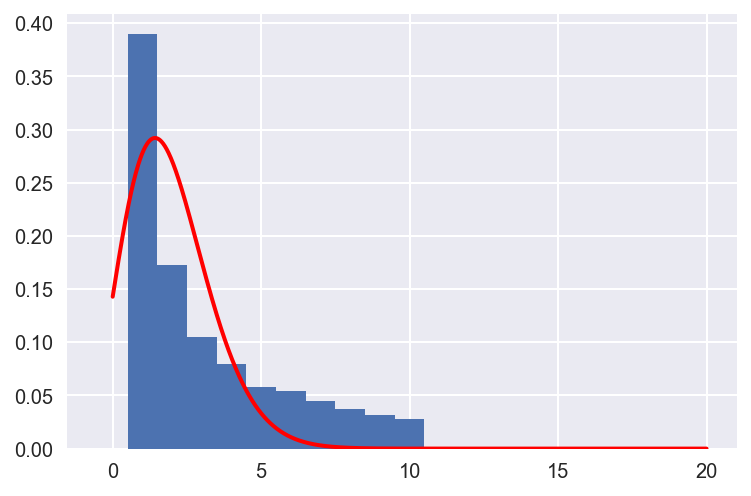

In [54]:

# Source: https://stackoverflow.com/questions/25828184/fitting-to-poisson-histogram

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.misc import factorial


# get poisson deviated random numbers
data = n_posts

# the bins should be of integer width, because poisson is an integer distribution
entries, bin_edges, patches = plt.hist(data, bins=11, range=[-0.5, 10.5], normed=True)

# calculate binmiddles
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

# poisson function, parameter lamb is the fit parameter
def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

# fit with curve_fit
parameters, cov_matrix = curve_fit(poisson, bin_middles, entries) 

# plot poisson-deviation with fitted parameter
x_plot = np.linspace(0, 20, 1000)

plt.plot(x_plot, poisson(x_plot, *parameters), 'r-', lw=2)
plt.show()

## Building Activity and Performance

### Listing counts by building (i.e. building activity)

In [124]:
df.query("building_id != '0'").shape

(41066, 14)

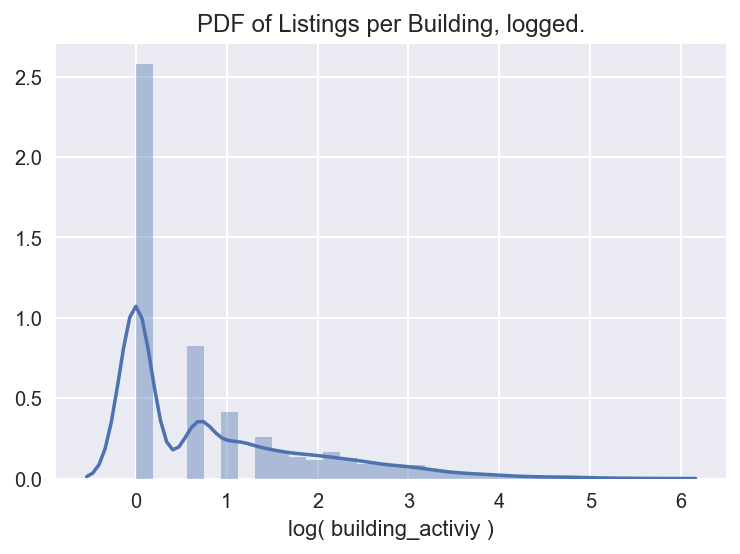

In [48]:
building_activiy = (df.query("building_id != '0'")
                      .building_id.value_counts()
                      .rename('building_activiy')
)

sns.distplot(np.log(building_activiy), bins=30)
plt.xlabel('log( building_activiy )')
plt.title('PDF of Listings per Building, logged.')

In [322]:
a, b = 4+4, 3

In [133]:
data.building_activiy.max()

2533.0

In [59]:
# see if activity of agents affects interest

prior = df.groupby('building_id')['interest_level'].mean().mean()
avg_int = (df.groupby('building_id')['interest_level']
             .apply(exp_int, prior)
             .rename('avg_interest')
)

building_activiy = df.manager_id.value_counts().rename('building_activiy')
data = pd.concat([building_activiy, avg_int], axis=1)

bins = [0, 1, 2, 3, 4, 6, 8, 12, 16, 25, 30, data.building_activiy.max()]

x = 'building_activiy'
hue = 'avg_interest'

hue_bins = [1, 1.5, 2, 2.5, 3]

plot_prob_x_for_hue(x=x, data=data, hue=hue, bins=bins, hue_bins=hue_bins)

# plt.savefig(''.join([REPORT_IMG_DIR, '11-building-act-on-avg-interest.png']),
#             dpi=600, bbox_inches='tight')

plt.show()

ValueError: Some x values fall outside bins.

## Feature Importance

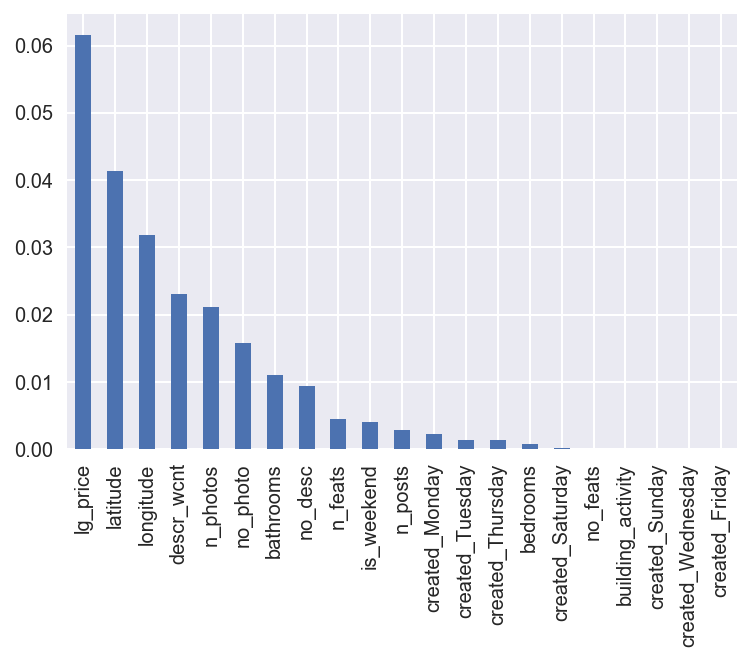

In [83]:
df = read_rental_interest(DF_TRAIN_PKL)

X, y = df.drop('interest_level', axis=1), df.interest_level

X_ = feature_prep(X)
X_ = extractor.fit_transform(X_)

discrete_features = [5]  # for boolean is_weekend
info = mutual_info_classif(X_, y, discrete_features=discrete_features,
                           random_state=SEED)
mi = pd.Series(info, index=columns).sort_values(ascending=False)
mi.plot('bar')

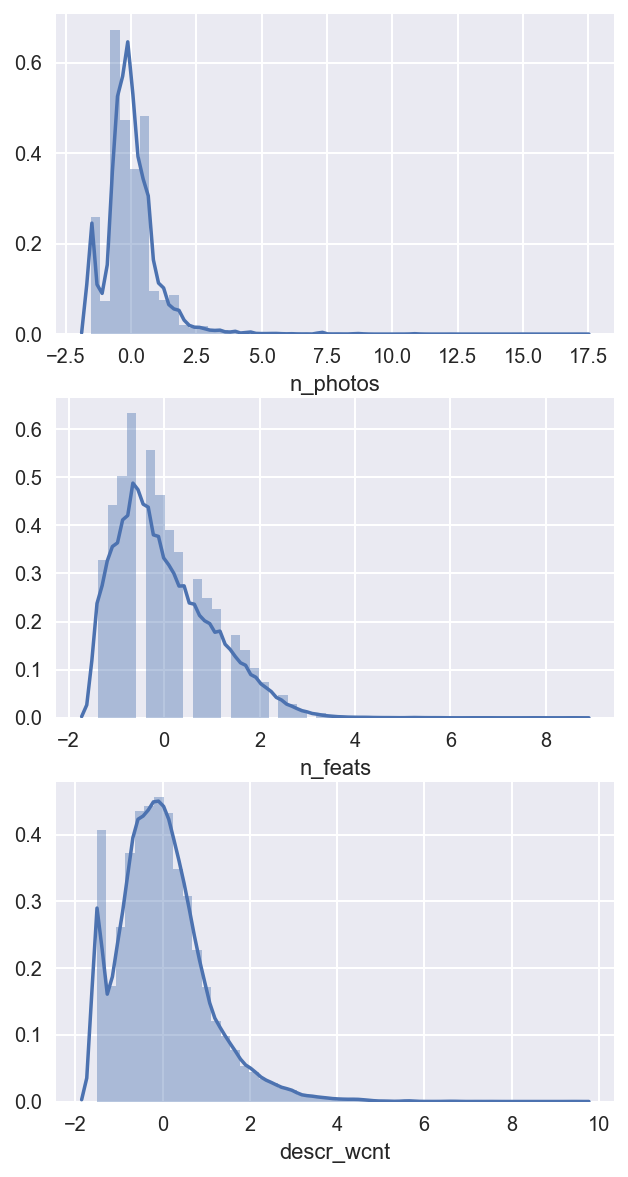

In [64]:
fig, axs = plt.subplots(nrows=3, figsize=(5, 10))

for (_, ser), ax in zip(data.items(), axs):
    sns.distplot(ser, ax=ax)

In [ ]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=200, n_jobs=N_JOBS, random_state=SEED)
forest.fit(X, y)


arr = np.vstack([tree.feature_importances_ for tree in forest.estimators_])
data = pd.DataFrame(arr, columns=X.columns)
data = data.reindex(columns=data.mean().sort_values(ascending=False).index)


sns.barplot(data=data)
plt.title('Feature importances')
plt.xticks(rotation=75)
plt.show()

## PCA

['22.461%', '17.837%', '15.471%', '12.635%', '7.539%', '4.877%', '4.054%', '2.924%', '2.785%', '2.661%', '1.664%', '1.524%', '1.428%', '0.986%', '0.854%', '0.299%', '0.000%', '0.000%']


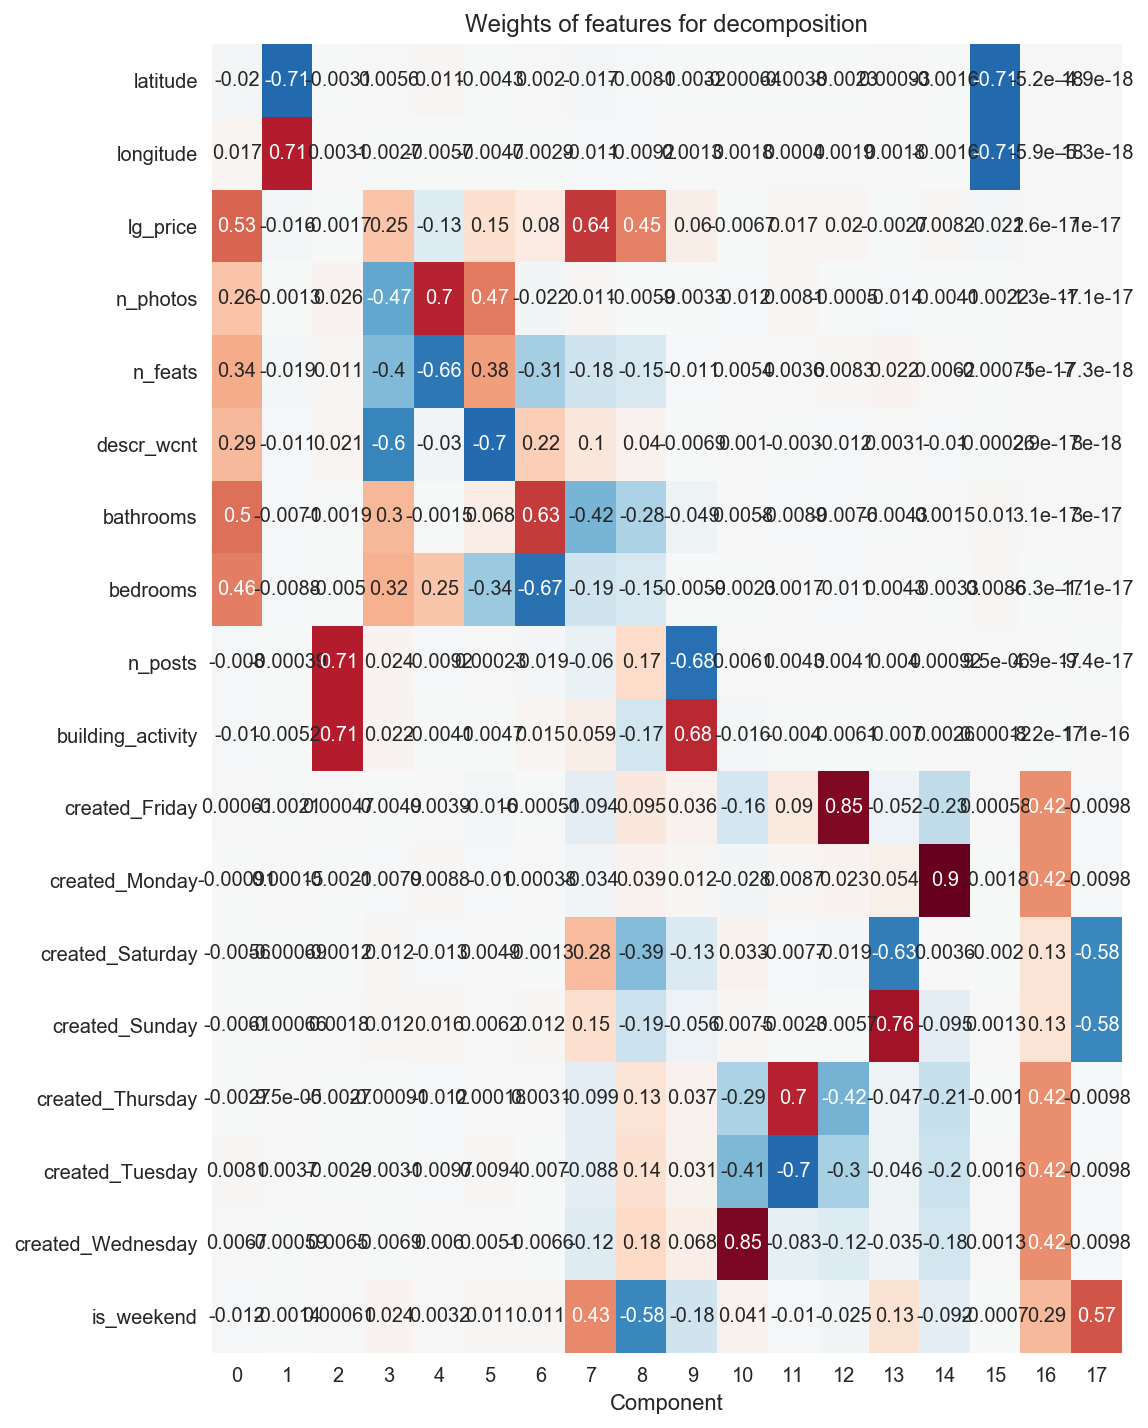

In [131]:
columns = [
    'latitude', 'longitude', 'lg_price', 'n_photos', 'n_feats',
    'descr_wcnt', 'bathrooms', 'bedrooms', 'n_posts', 'building_activity',
]

X = extractor.fit_transform(feature_prep(df))[:, :-8]

reducer = PCA()

reduced = reducer.fit_transform(X)
explained_variance = reducer.explained_variance_ratio_
print(['{:.3%}'.format(x) for x in explained_variance])

plt.figure(figsize=(8, 10))
sns.heatmap(reducer.components_.T, yticklabels=columns[:-8],
            cbar=False, annot=True)

plt.title('Weights of features for decomposition')
plt.xlabel('Component')

plt.tight_layout();

In [326]:
from scipy.cluster import hierarchy

ytdist = np.array([662., 877., 255., 412., 996., 295., 468., 268.,
                   400., 754., 564., 138., 219., 869., 669.])
Z = hierarchy.linkage(X, 'single')
plt.figure()
dn = hierarchy.dendrogram(Z)

hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
dn1 = hierarchy.dendrogram(Z, ax=axes[0], above_threshold_color='y',
                           orientation='top')
dn2 = hierarchy.dendrogram(Z, ax=axes[1], above_threshold_color='#bcbddc',
                           orientation='right')
hierarchy.set_link_color_palette(None)  # reset to default after use
plt.show()

NameError: name 'X' is not defined

In [35]:
from hdbscan import HDBSCAN


clusterer = HDBSCAN().fit(X)

In [36]:
two_d = reduced[:, :2]

with sns.axes_style('white'):
    sns.lmplot(*two_d.T, hue=clusterer.labels_,
                scatter_kws=dict(edgecolor='w', lw=.6, s=20)
)
plt.show()

TypeError: lmplot() missing 1 required positional argument: 'data'